In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required Libraries
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
import torchvision
import pandas as pd
import torchxrayvision as xrv
import skimage.io
import seaborn as sns
import ast
import os
import re
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])



In [3]:
def create_plot(x, y_label, title, kind='bar', color=['Tomato', 'CornflowerBlue'], legend_label=None, figsize=(15, 10)):
    # Set the figure size
    plt.figure(figsize=figsize)
    
    # If kind is a histogram, use black lines around the edges
    edgecolor = 'black' if kind == 'hist' else None

    # Sort the data if it's a Pandas Series
    if isinstance(x, pd.Series):
        x = x.sort_values(ascending=False)
    # Sort the data if it's a Pandas DataFrame (by the sum of values across rows)
    elif isinstance(x, pd.DataFrame):
        x = x.sort_values(by=x.columns[0], ascending=False)

    # Print the values
    if kind == 'hist':
        print(x.value_counts().sort_index())
    else:
        print(x)

    # Plot the data
    ax = x.plot(kind=kind, color=color, edgecolor=edgecolor, figsize=figsize) # You can also set figsize here if needed
    plt.ylabel(y_label)
    plt.title(title)

    # If a legend label is provided and the plot is not a histogram, add the legend
    if legend_label and kind != 'hist':
        ax.legend(legend_label)
    
    plt.xticks(rotation=45)
    plt.show()


In [4]:
def create_aggregated_plot(data, columns, y_label, title, bins=None, kind='bar', color=['Tomato', 'CornflowerBlue'], figsize=(15, 10)):
    if kind == 'hist' and bins:
        # Define the age bins and labels
        age_bins = bins
        age_labels = [f'{age_bins[i]}-{age_bins[i + 1]}' for i in range(len(age_bins) - 1)]

        # Create a new column 'age_group' with the binned ages
        data['age_group'] = pd.cut(data[columns[1]], bins=age_bins, labels=age_labels, right=False)
        columns[1] = 'age_group'

        # Group by the 'group_by' column and count occurrences
        aggregated_data = data.groupby(columns).size().reset_index(name='Count')
        aggregated_data = aggregated_data.sort_values(by='Count', ascending=False)

        # Print the aggregated data as a table
        print(aggregated_data.to_string(index=False))

        # Create a bar plot using seaborn
        plt.figure(figsize=figsize)
        sns.barplot(data=aggregated_data, x=columns[0], y='Count', hue=columns[1], palette=color)

        plt.xlabel(columns[0].capitalize())
        plt.ylabel('Count')
        plt.legend(title=y_label)
    else:
        # Print the aggregated data as a table
        print(pd.crosstab(data[columns[0]], data[columns[1]]).to_string())

        # Create a figure with specified size
        plt.figure(figsize=figsize)
        aggregated_data = pd.crosstab(data[columns[0]], data[columns[1]])
        aggregated_data.plot(kind=kind, color=color, figsize=figsize)  # You can also set figsize here if needed

    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()


In [5]:
def plot_multicol_aggregated_findings(data, columns_to_plot, group_by, title, color, figsize=(15, 12)):
    # Define a function to count the occurrences of '1' for each condition in columns_to_plot
    def count_occurrences(group):
        return (group[columns_to_plot] == 1).sum()

    # Group by the 'group_by' column and apply the counting function to each group
    aggregated_data = data.groupby(group_by).apply(count_occurrences).reset_index()

    # Compute the total count for each group and sort by this total
    aggregated_data['total_count'] = aggregated_data[columns_to_plot].sum(axis=1)
    aggregated_data = aggregated_data.sort_values(by='total_count', ascending=False)

    # Melt the DataFrame to match the format expected by seaborn
    melted_data = pd.melt(aggregated_data, id_vars=[group_by], value_vars=columns_to_plot, var_name='Finding', value_name='Count')

    # Sort melted_data by both 'group_by' and 'Count'
    melted_data['group_order'] = melted_data[group_by].map(aggregated_data.reset_index().set_index(group_by)['index'])
    melted_data = melted_data.sort_values(by=['group_order', 'Count'], ascending=[True, False])

    print('Grouped Data')
    print(melted_data)

    # Create a bar plot using seaborn with the specified figure size
    plt.figure(figsize=figsize)
    sns.barplot(data=melted_data, x=group_by, y='Count', hue='Finding', palette=color, order=aggregated_data[group_by])

    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(group_by.capitalize())
    plt.legend(title='Findings')
    plt.show()



In [6]:
#Load PadChest data
d_pad = xrv.datasets.PC_Dataset(imgpath="/", views=["PA","AP"], unique_patients=False)
d_pad.csv

#CSV Paths
metadata_path = "/ssd2/jpmokc/datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv.gz"
cheXpert_path = "/ssd2/jpmokc/datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv.gz"

#Load MIMIC data
d_mimic = xrv.datasets.MIMIC_Dataset(imgpath="/", csvpath=cheXpert_path, metacsvpath=metadata_path, unique_patients=False, views=['AP','PA'])

# Load CheXpert Dataset
d_chex = xrv.datasets.CheX_Dataset( imgpath="/",
                                    csvpath="/ssd/averijordan/csv/train.csv",
                                    unique_patients=False,
                                    transform=transform,
                                    views=['AP','PA']
                                  )

# Load NIH Dataset
d_nih = xrv.datasets.NIH_Dataset( imgpath="/",
                                  unique_patients=False, 
                                  transform=transform,
                                  views=['AP','PA']
                                )



In [7]:
d_mimic.csv.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'PerformedProcedureStepDescription', 'ViewPosition', 'Rows',
       'Columns', 'StudyDate', 'StudyTime',
       'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'view', 'offset_day_int',
       'patientid'],
      dtype='object')

Text(0.5, 1.0, 'View Types')

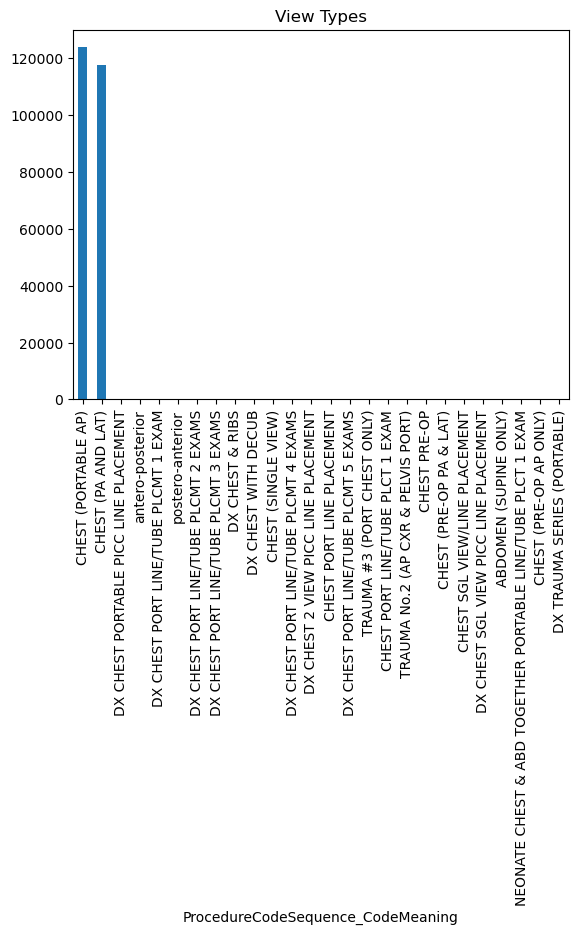

In [8]:
#Get view types
d_views = d_mimic.csv['ProcedureCodeSequence_CodeMeaning']

#Get the count of appearences of each view
views_counts = d_views.value_counts()

#Plot
views_counts_plot = views_counts.plot(kind="bar")
views_counts_plot.set_title("View Types")



In [9]:
#Seperate columns with labelling
d_mimic_labels = pd.concat([d_mimic.csv['view'],d_mimic.csv['Atelectasis'], d_mimic.csv['Cardiomegaly'],
       d_mimic.csv['Consolidation'], d_mimic.csv['Edema'], d_mimic.csv['Enlarged Cardiomediastinum'], d_mimic.csv['Fracture'],
       d_mimic.csv['Lung Lesion'], d_mimic.csv['Lung Opacity'], d_mimic.csv['No Finding'], d_mimic.csv['Pleural Effusion'],
       d_mimic.csv['Pleural Other'], d_mimic.csv['Pneumonia'], d_mimic.csv['Pneumothorax']], axis=1)


expanded_colors = [
    '#EC9706', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7',
    '#FDA172', '#BAD5EC', '#A6E4DD', '#FBC246', '#144668', '#9A1000', '#C23584'
]


Pleural Effusion              57721
Lung Opacity                  54769
Atelectasis                   48790
Cardiomegaly                  47673
Edema                         29331
Pneumonia                     17222
Consolidation                 11525
Pneumothorax                  11235
Enlarged Cardiomediastinum     7657
Lung Lesion                    6632
Fracture                       4781
Pleural Other                  2083
view                              0
dtype: int64


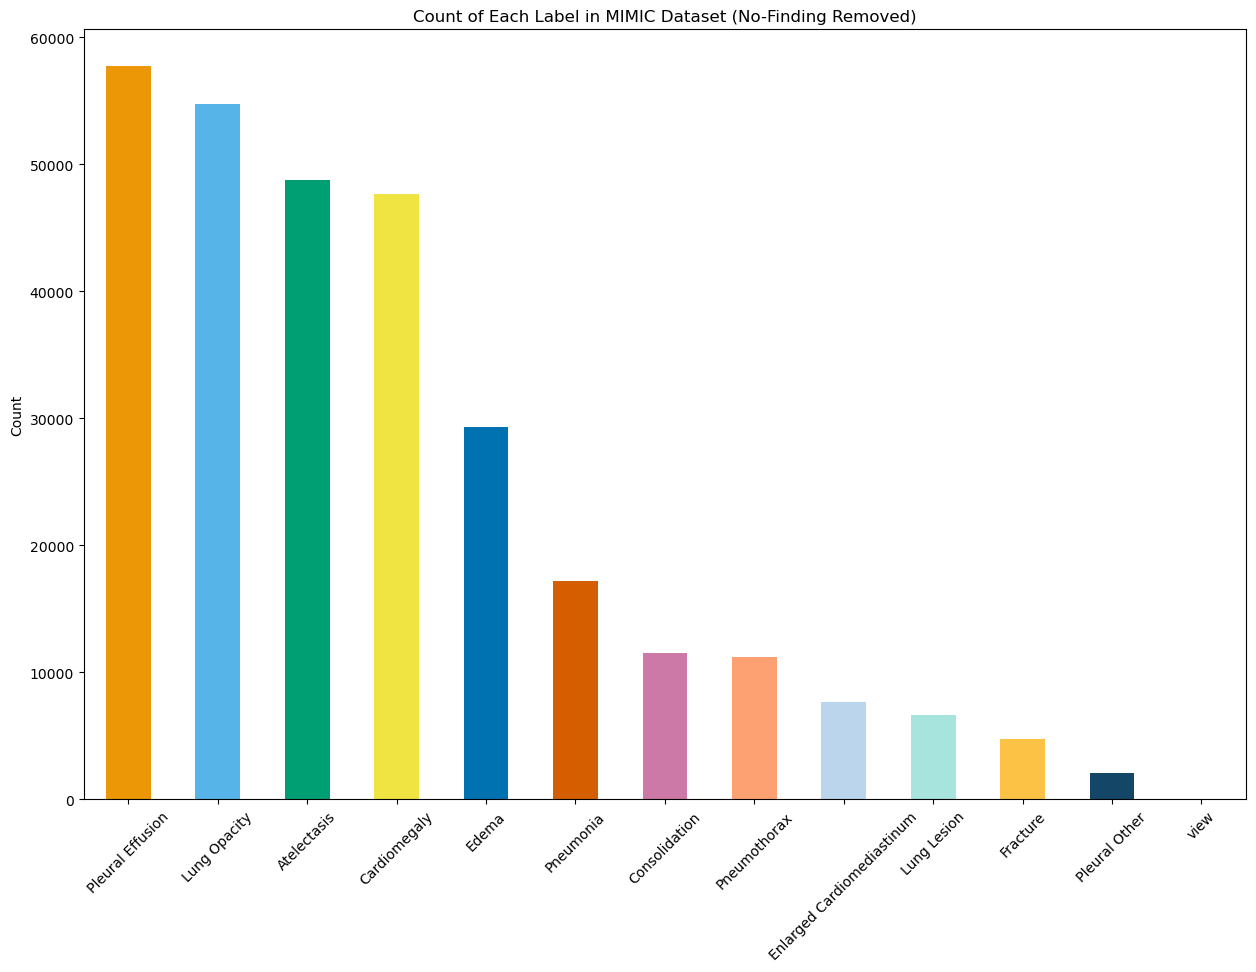

No Finding                    81117
Pleural Effusion              57721
Lung Opacity                  54769
Atelectasis                   48790
Cardiomegaly                  47673
Edema                         29331
Pneumonia                     17222
Consolidation                 11525
Pneumothorax                  11235
Enlarged Cardiomediastinum     7657
Lung Lesion                    6632
Fracture                       4781
Pleural Other                  2083
view                              0
dtype: int64


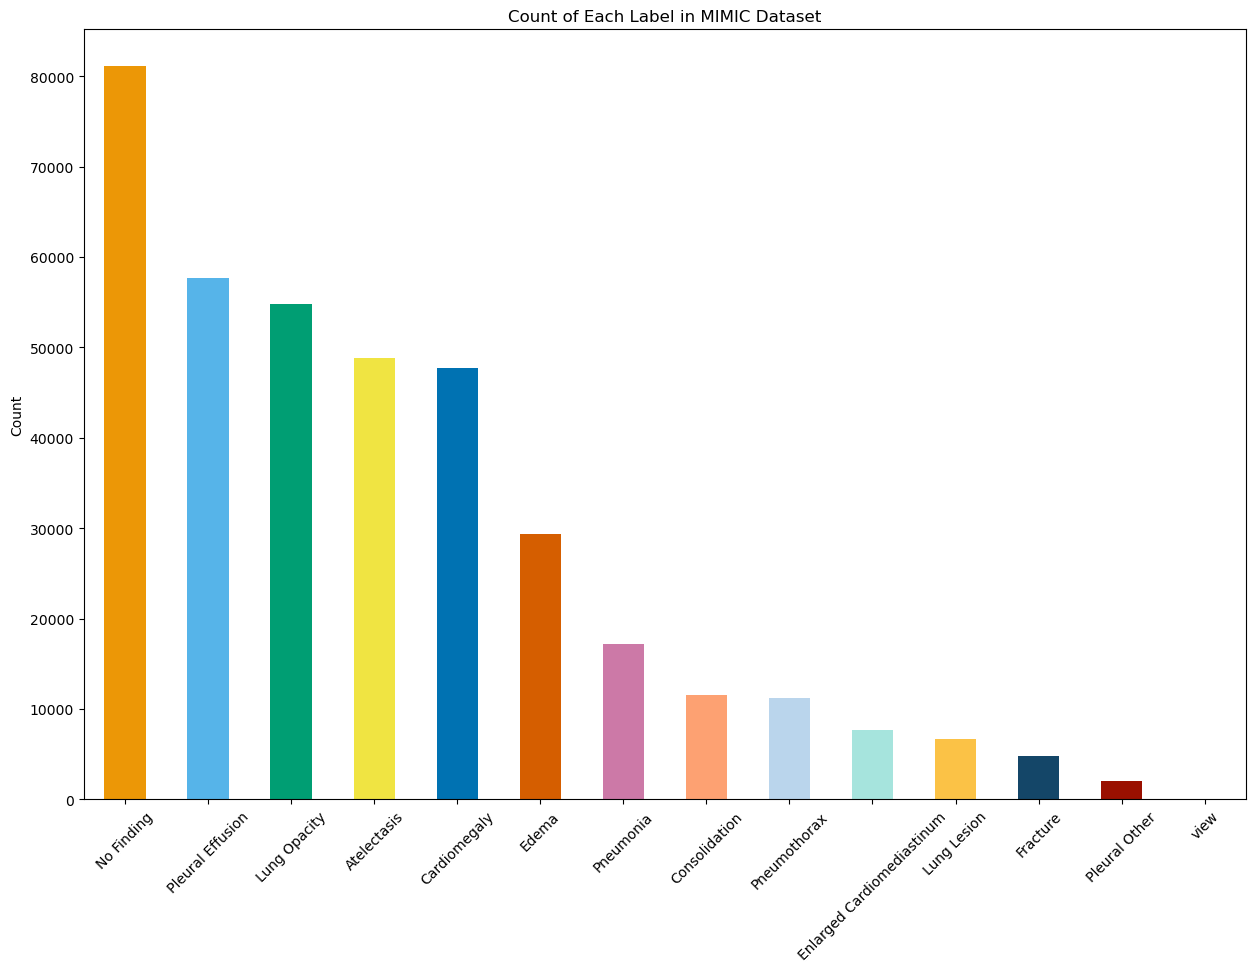

In [10]:

# Get counts of each column with rows that equal 1 and sort them
label_counts = d_mimic_labels.eq(1).sum(axis=0).sort_values(ascending=False)

# Drop 'No Finding' from the count
label_counts_dropped = label_counts.drop('No Finding')

# Use the create_plot function for visualization
create_plot(label_counts_dropped, y_label='Count', title='Count of Each Label in MIMIC Dataset (No-Finding Removed)', color=expanded_colors)
create_plot(label_counts, y_label='Count', title='Count of Each Label in MIMIC Dataset',  color=expanded_colors)



Grouped Data
   view                     Finding  Count  group_order
18   AP            Pleural Effusion  45657            0
14   AP                Lung Opacity  40944            0
0    AP                 Atelectasis  38714            0
2    AP                Cardiomegaly  37842            0
16   AP                  No Finding  31252            0
6    AP                       Edema  26202            0
22   AP                   Pneumonia  11389            0
4    AP               Consolidation   9670            0
24   AP                Pneumothorax   8885            0
8    AP  Enlarged Cardiomediastinum   6111            0
12   AP                 Lung Lesion   3544            0
10   AP                    Fracture   2827            0
20   AP               Pleural Other   1040            0
17   PA                  No Finding  49865            1
15   PA                Lung Opacity  13825            1
19   PA            Pleural Effusion  12064            1
1    PA                 Atelectasis

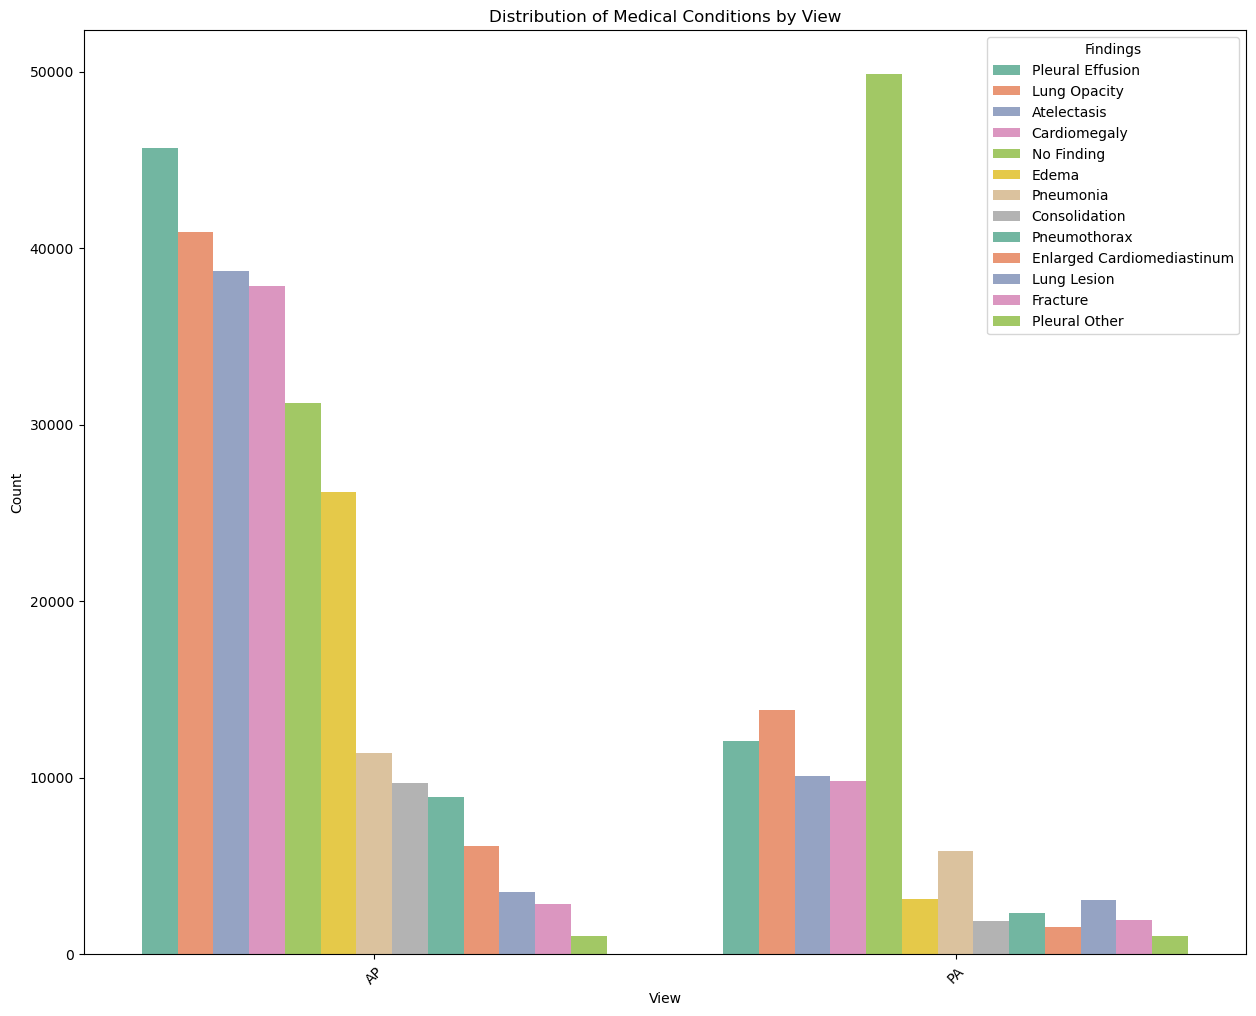

In [11]:
# Prepare data by converting negative values to NaN
d_mimic_labels[d_mimic_labels.columns[1:]] = d_mimic_labels[d_mimic_labels.columns[1:]].applymap(lambda x: np.nan if x < 0 else x)

# Columns representing medical conditions
columns_to_plot = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
                   'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax']

# Use the plot_multicol_aggregated_findings function
plot_multicol_aggregated_findings(d_mimic_labels, columns_to_plot=columns_to_plot, group_by='view', 
                                  title='Distribution of Medical Conditions by View', 
                                  color='Set2', figsize=(15, 12))

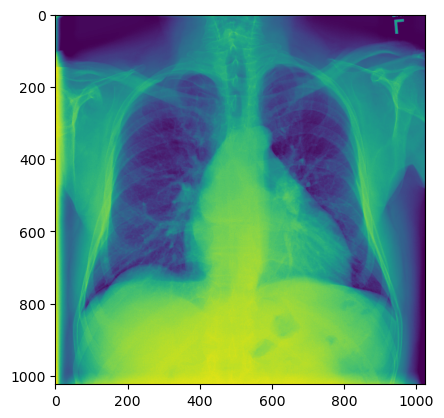

In [12]:
# Define the file path of the image
file_path = '/ssd/averijordan/datasets/ChestXray-NIHCC/images_001/images/00000001_000.png' # Replace 'your_image_filename.jpg' with the actual filename of the image you want to load

# Load the image using skimage.io.imread
img = skimage.io.imread(file_path)
plt.imshow(img)
plt.show()

In [13]:
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
print(img.shape)
# Check that images are 2D arrays
if len(img.shape) > 2:
    img = img[:, :, 0]
if len(img.shape) < 2:
    print("error, dimension lower than 2 for image")
# Add color channel
img = img[None, :, :]
print(img.shape)


(1024, 1024)
(1, 1024, 1024)


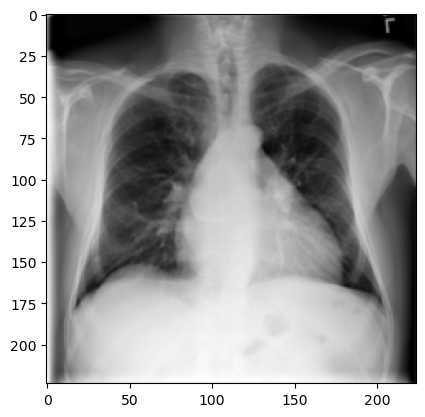

In [14]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
img = transform(img)
plt.imshow(img[0],cmap='gray')
plt.show()

In [15]:
d_nih_csv = deepcopy(d_nih.csv)
d_chex_csv = deepcopy(d_chex.csv)


In [16]:
d_nih_csv

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],view,has_masks,patientid,age_years,sex_male,sex_female
0,0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,PA,False,1,57.0,True,False
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,PA,False,1,58.0,True,False
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,PA,False,1,58.0,True,False
3,3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,PA,False,2,80.0,True,False
4,4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,PA,False,3,74.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168,PA,False,30801,38.0,True,False
112116,112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,PA,False,30802,28.0,True,False
112117,112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,PA,False,30803,42.0,False,True
112118,112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,PA,False,30804,29.0,False,True


In [17]:
d_chex_csv

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,view,patientid,age_years,sex_male,sex_female
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68.0,Frontal,AP,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,AP,00001,68.0,False,True
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87.0,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,1.0,NaN,AP,00002,87.0,False,True
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83.0,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,AP,00002,83.0,False,True
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41.0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,AP,00003,41.0,True,False
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20.0,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,PA,00004,20.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59.0,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,0.0,1.0,NaN,NaN,NaN,AP,64537,59.0,True,False
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59.0,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,NaN,-1.0,NaN,NaN,NaN,AP,64537,59.0,True,False
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,NaN,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,AP,64538,0.0,False,True
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,NaN,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,0.0,NaN,NaN,NaN,0.0,AP,64539,0.0,False,True


In [18]:
print(d_chex.csv.columns)
print(d_nih.csv.columns)

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'view', 'patientid', 'age_years', 'sex_male',
       'sex_female'],
      dtype='object')
Index(['index', 'Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'view', 'has_masks',
       'patientid', 'age_years', 'sex_male', 'sex_female'],
      dtype='object')


In [19]:
d_chex_csv = d_chex_csv[d_chex_csv['Frontal/Lateral'] != 'Lateral']

Sex
Male       112139
Female      78870
Unknown         1
Name: count, dtype: int64


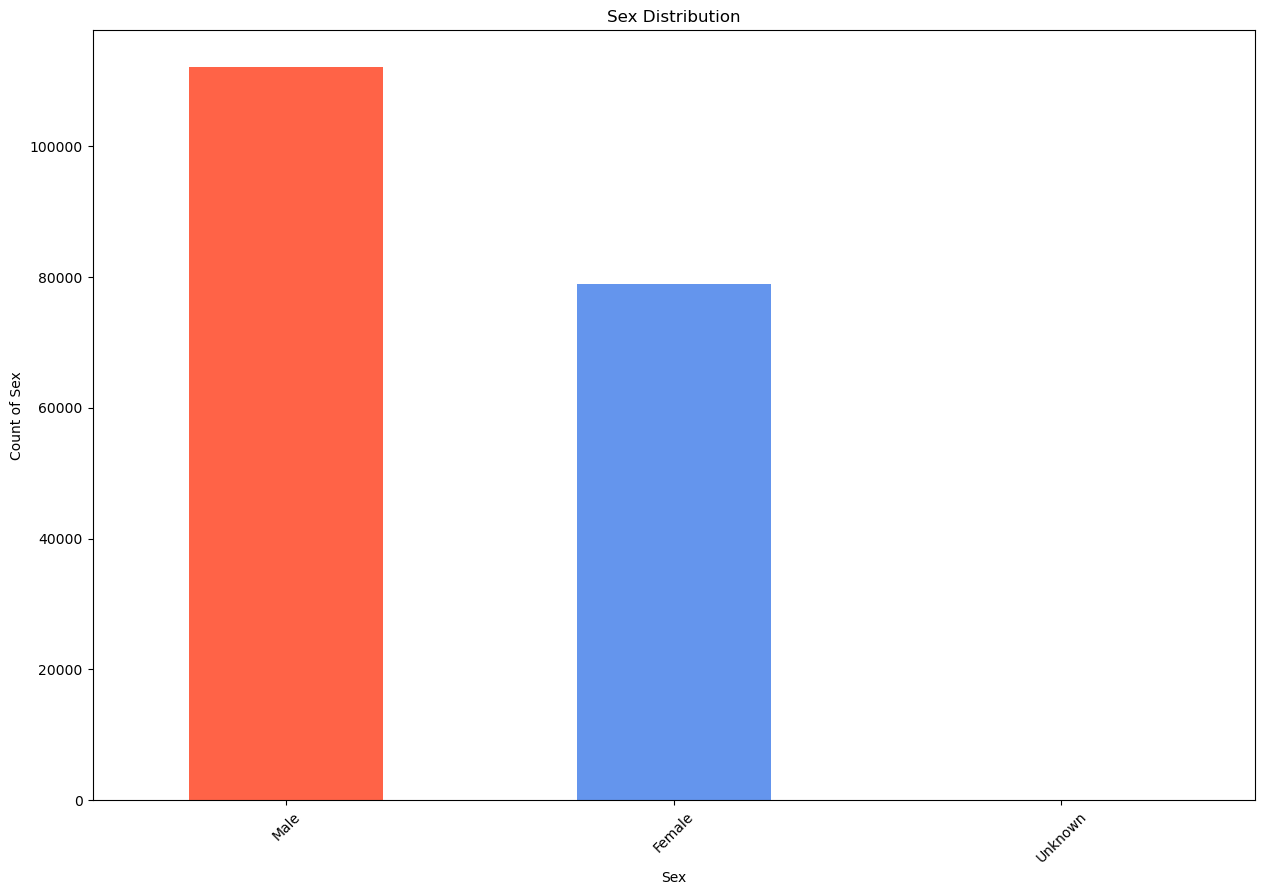

In [20]:
# Get sex count and plot
sex = d_chex_csv['Sex'].value_counts()
create_plot(sex, y_label='Count of Sex',title='Sex Distribution', color=['Tomato', 'CornflowerBlue', 'OliveDrab'])


view
AP    161590
PA     29420
Name: count, dtype: int64


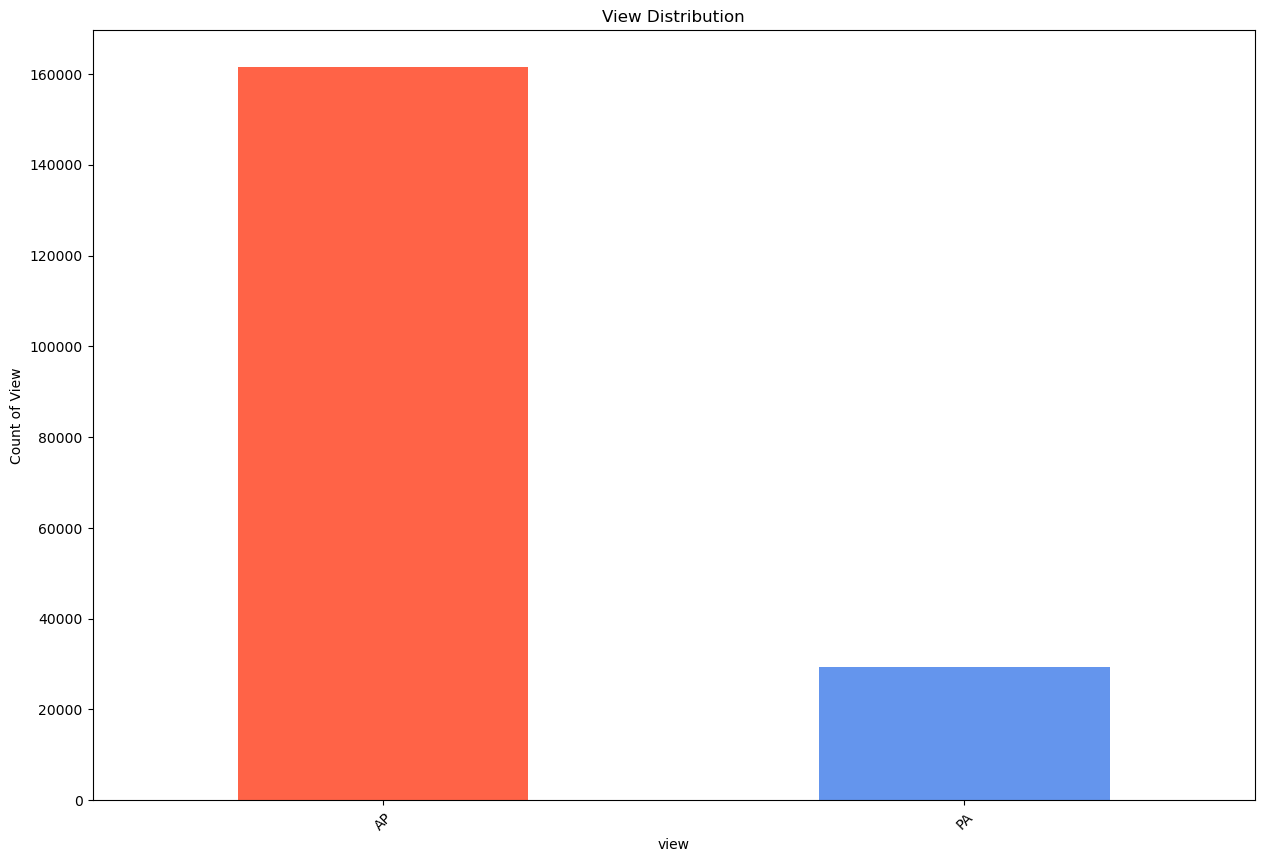

In [21]:
# Get view count and plot
view = d_chex_csv['view'].value_counts()
create_plot(view, y_label='Count of View', title='View Distribution')


Age
18.0     662
19.0    1040
20.0    1103
21.0    1077
22.0    1143
        ... 
86.0    2064
87.0    2083
88.0    1857
89.0    1778
90.0    6550
Name: count, Length: 73, dtype: int64


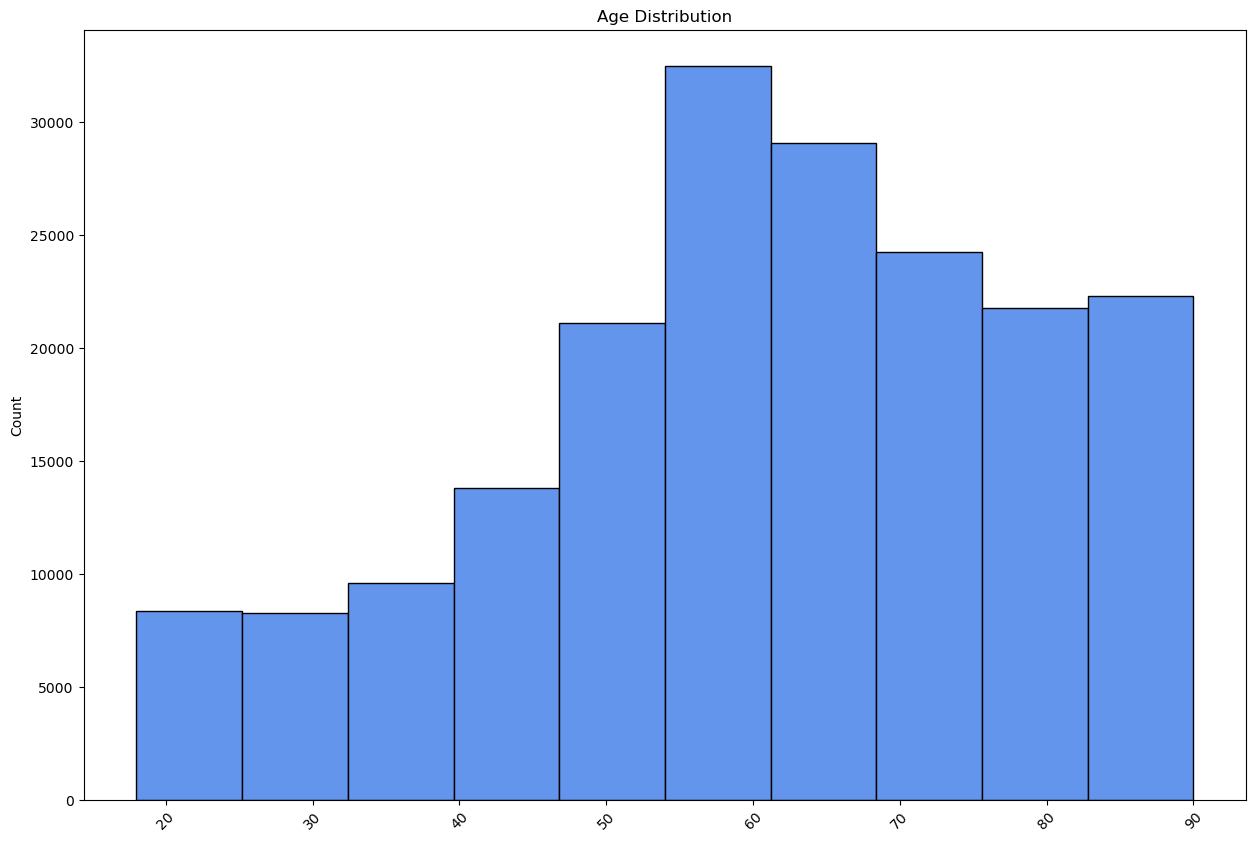

In [22]:
# Get age count and plot
age = d_chex_csv['Age']
# Call the create_plot function to create a histogram of the age distribution
create_plot(age, y_label='Count', title='Age Distribution', kind='hist', color=['CornflowerBlue'])


Support Devices               107167
Lung Opacity                   94207
Pleural Effusion               76894
Edema                          49674
Atelectasis                    29718
Cardiomegaly                   23384
Pneumothorax                   17693
No Finding                     16970
Consolidation                  12982
Enlarged Cardiomediastinum      9186
Fracture                        7434
Lung Lesion                     7040
Pneumonia                       4674
Pleural Other                   2503
dtype: int64


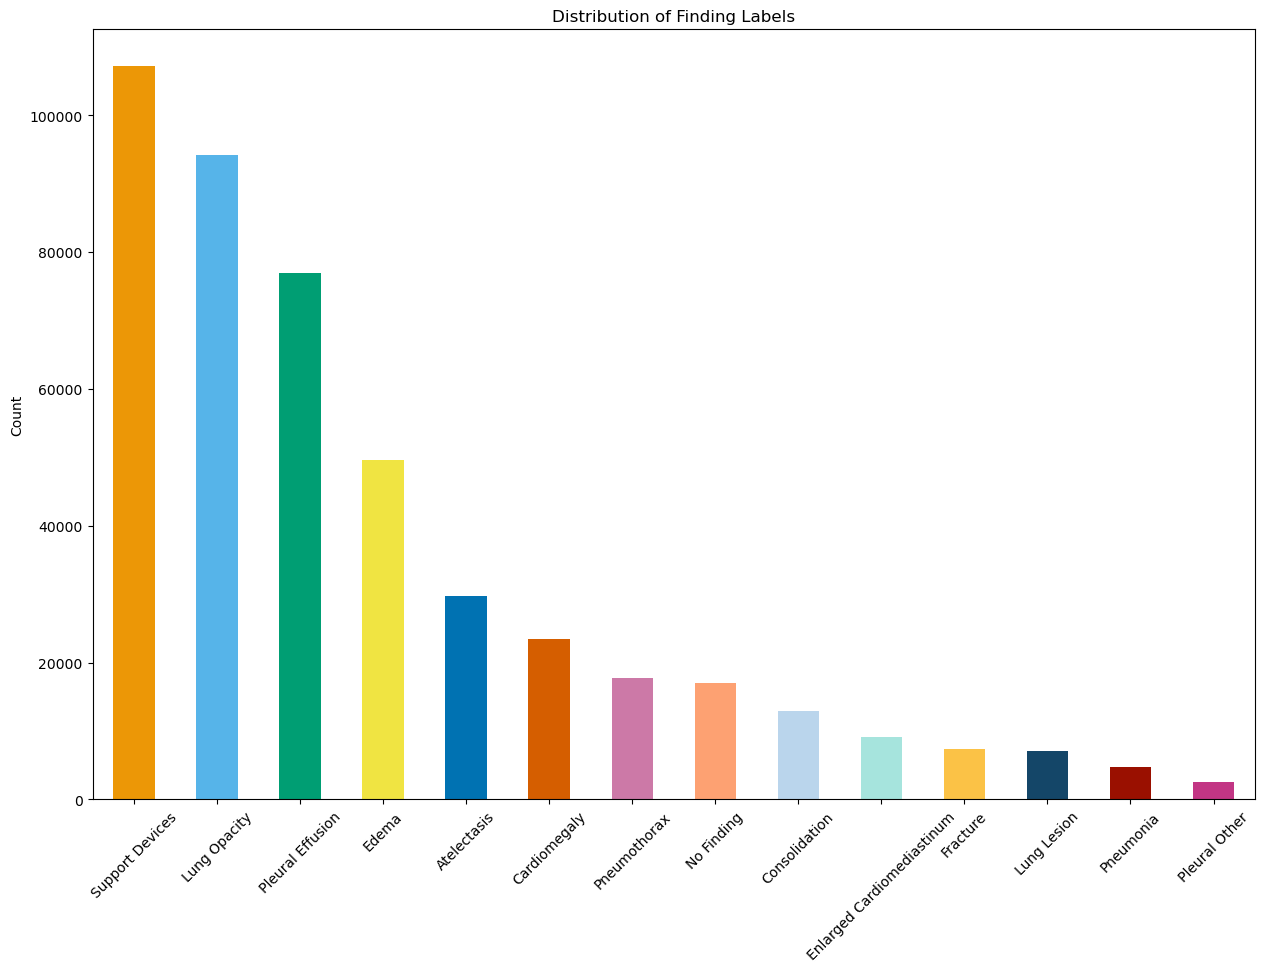

In [23]:
# Columns you want to count
columns_to_plot = [
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

# Count the occurrences of '1' for each condition (column)
positive = {col: (d_chex_csv[col] == 1).sum() for col in columns_to_plot}

# Convert the dictionary to a Pandas Series
counts = pd.Series(positive)

create_plot(counts, y_label='Count', title='Distribution of Finding Labels', color=expanded_colors)


In [24]:
# Define the age bins and labels
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

Sex   Female   Male  Unknown
view                        
AP     68736  92854        0
PA     10134  19285        1


<Figure size 1500x1000 with 0 Axes>

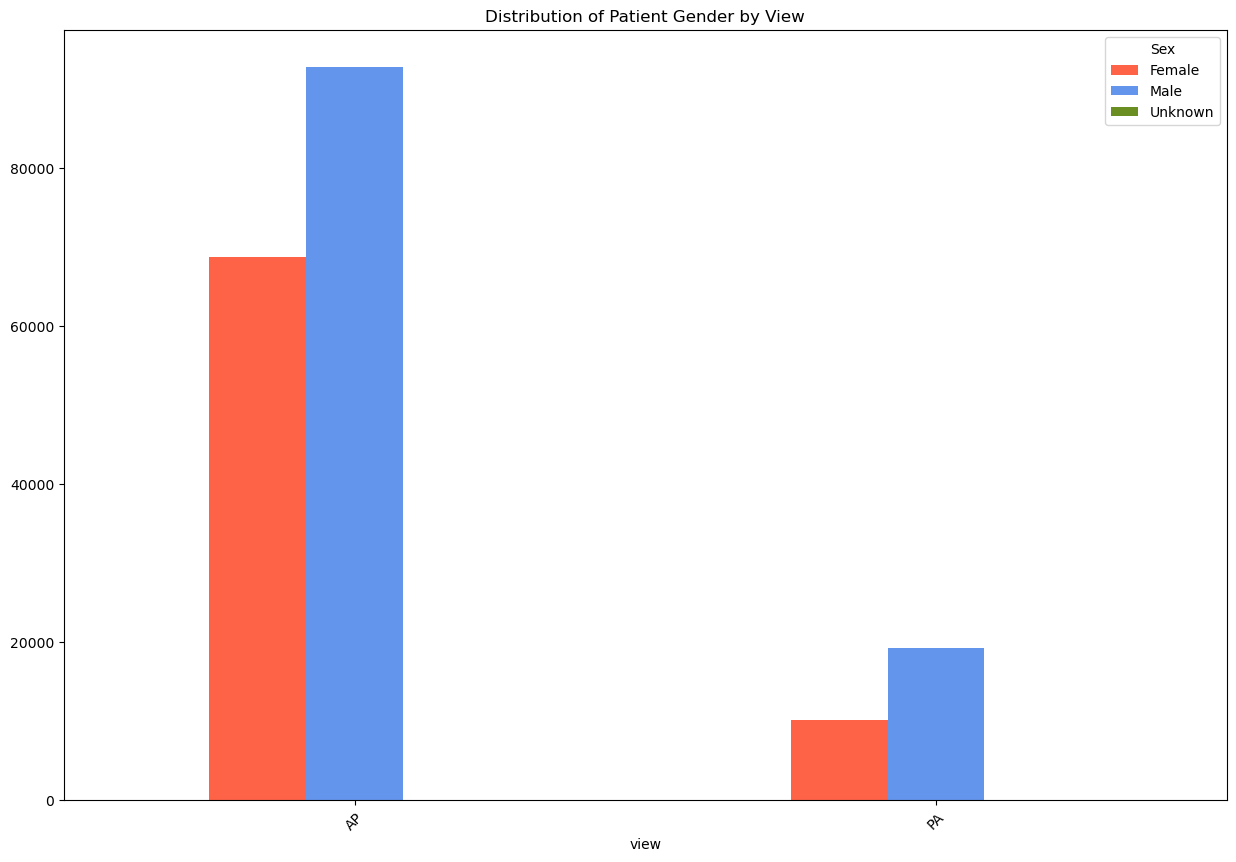

In [25]:
create_aggregated_plot(d_chex_csv, ['view', 'Sex'], y_label='Count', title='Distribution of Patient Gender by View',color=['Tomato', 'CornflowerBlue', 'OliveDrab'])


    Sex age_group  Count
   Male     60-70  25916
   Male     50-60  22545
   Male     70-80  19330
 Female     60-70  15833
 Female     50-60  14293
 Female     70-80  13824
   Male     80-90  13172
   Male     40-50  12656
 Female     80-90  11485
 Female     40-50   9142
   Male     30-40   7661
   Male     20-30   6796
 Female     30-40   5637
 Female     20-30   4464
 Female    90-100   3536
   Male    90-100   3014
   Male      0-20   1049
 Female      0-20    653
Unknown     30-40      1
Unknown      0-20      0
Unknown     20-30      0
Unknown     40-50      0
Unknown     50-60      0
Unknown     60-70      0
Unknown     70-80      0
Unknown     80-90      0
Unknown    90-100      0


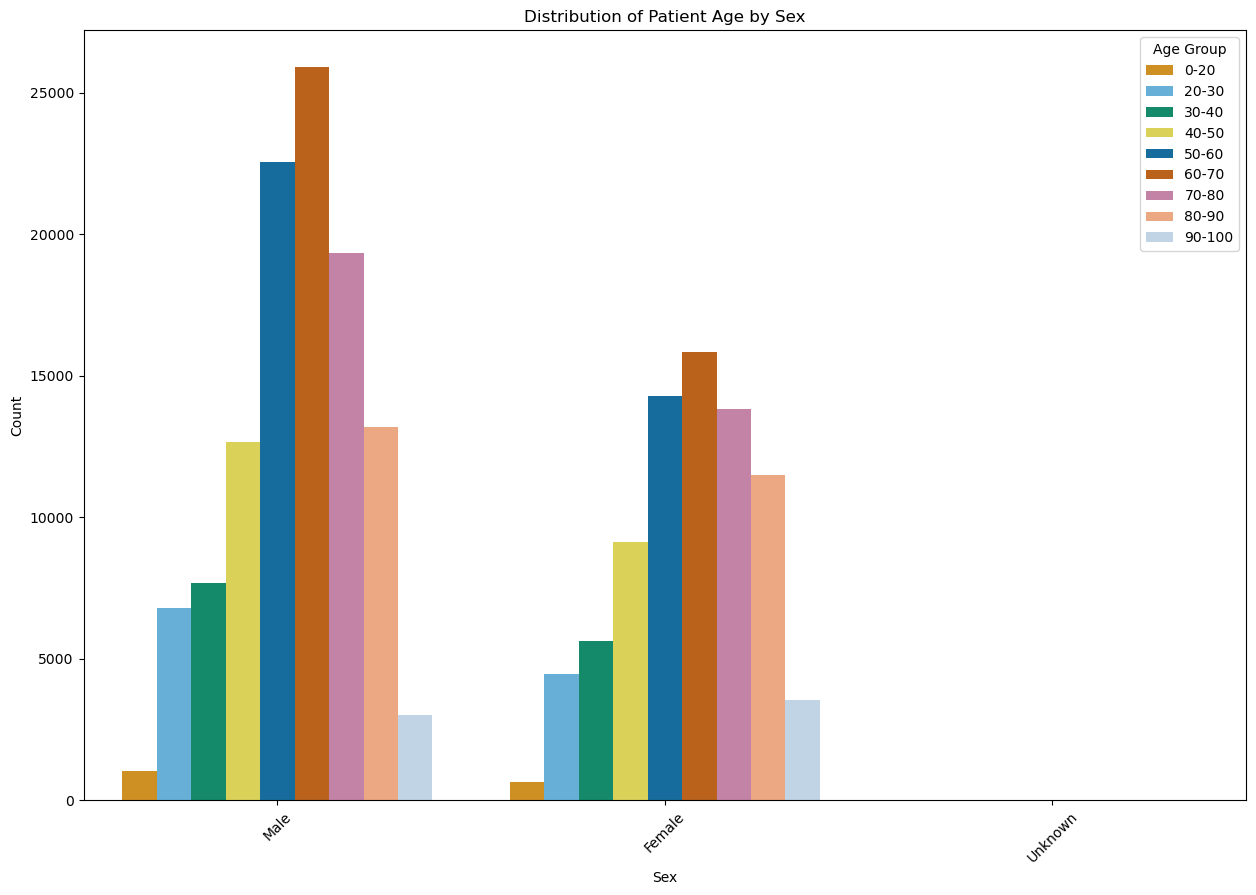

In [26]:
create_aggregated_plot(d_chex_csv, ['Sex', 'Age'], y_label='Age Group', title='Distribution of Patient Age by Sex', kind='hist',bins=age_bins, color=expanded_colors)


view age_group  Count
  AP     60-70  35013
  AP     50-60  30475
  AP     70-80  28850
  AP     80-90  22226
  AP     40-50  17871
  AP     30-40  10561
  AP     20-30   9062
  PA     60-70   6736
  PA     50-60   6363
  AP    90-100   6073
  PA     70-80   4304
  PA     40-50   3927
  PA     30-40   2738
  PA     80-90   2431
  PA     20-30   2198
  AP      0-20   1456
  PA    90-100    477
  PA      0-20    246


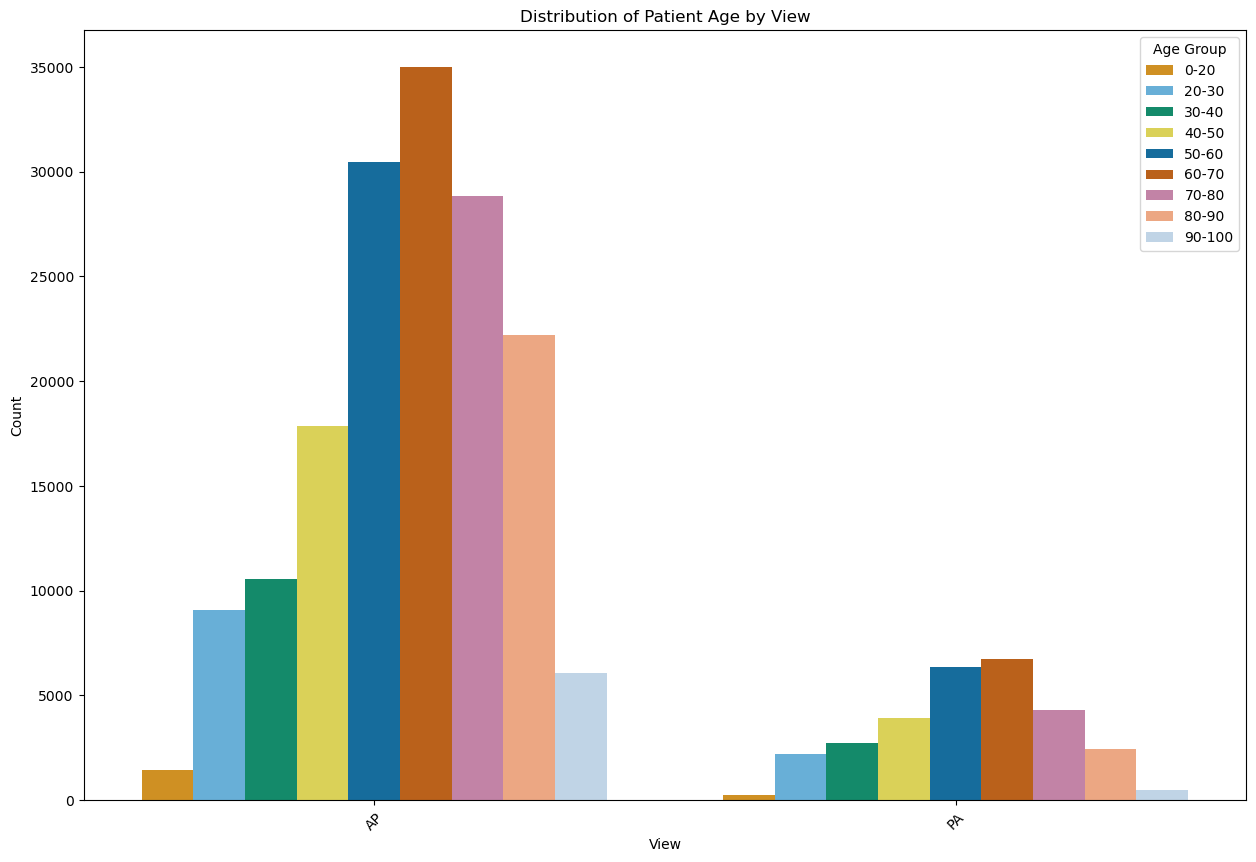

In [27]:
create_aggregated_plot(d_chex_csv, ['view', 'Age'], y_label='Age Group', title='Distribution of Patient Age by View', kind='hist',bins=age_bins, color=expanded_colors)


Grouped Data
    age_group           Finding  Count group_order
125      0-20   Support Devices    932           0
35       0-20      Lung Opacity    642           0
98       0-20  Pleural Effusion    498           0
8        0-20        No Finding    311           0
53       0-20             Edema    260           0
..        ...               ...    ...         ...
70     91-100         Pneumonia    255           8
88     91-100      Pneumothorax    225           8
7      91-100        No Finding    201           8
43     91-100       Lung Lesion    195           8
106    91-100     Pleural Other    126           8

[126 rows x 4 columns]


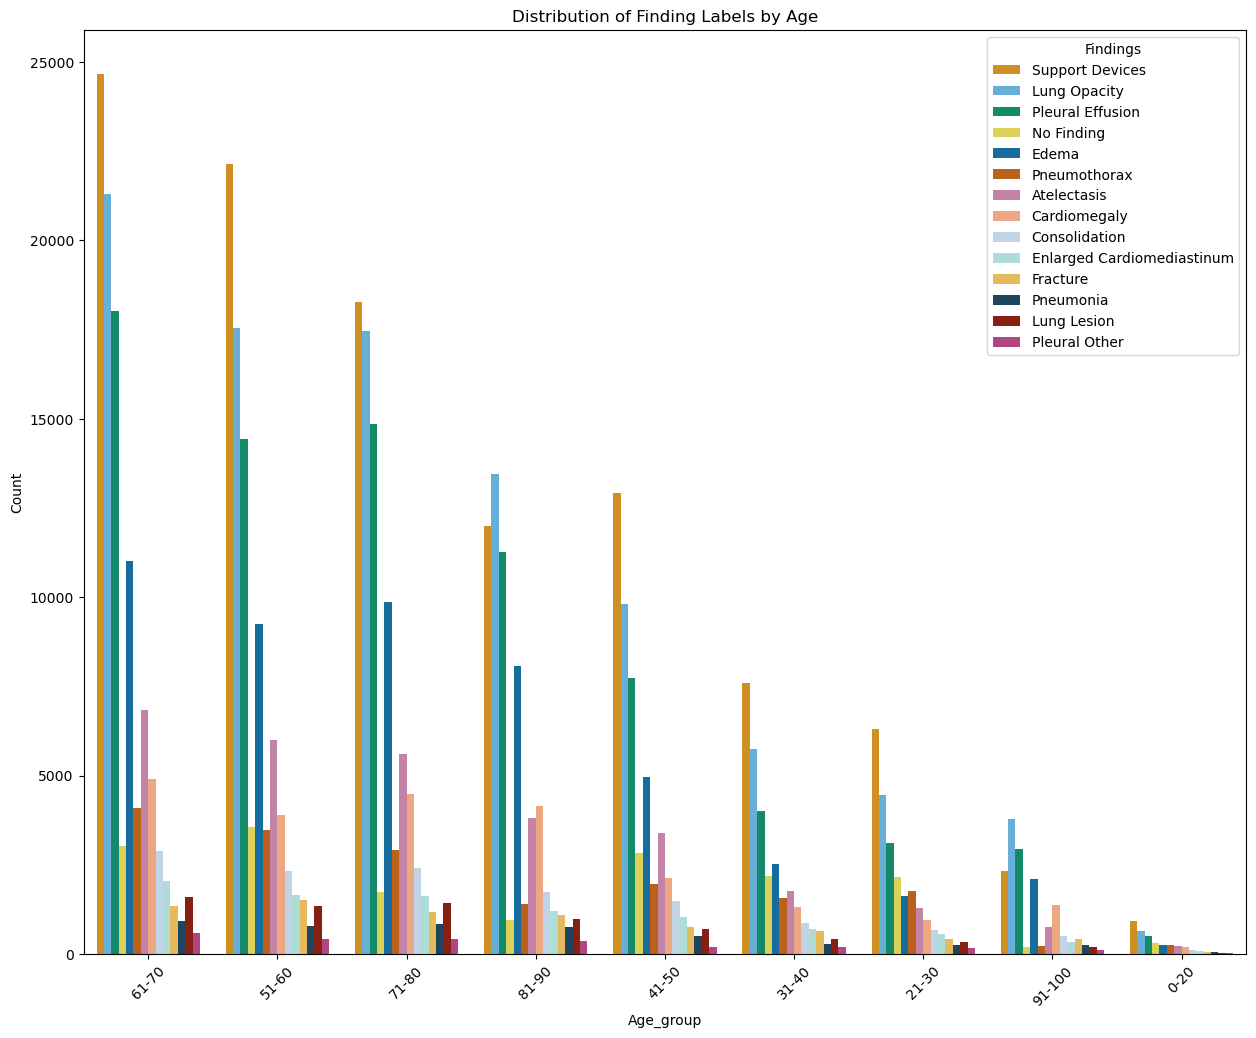

In [28]:
# Create a new column 'age_group' with the binned ages
d_chex_csv['age_group'] = pd.cut(d_chex_csv['Age'], bins=age_bins, labels=age_labels, right=False)
plot_multicol_aggregated_findings(d_chex_csv, columns_to_plot, 'age_group', 'Distribution of Finding Labels by Age', expanded_colors)


Grouped Data
   view                     Finding  Count  group_order
26   AP             Support Devices  99028            0
6    AP                Lung Opacity  84471            0
20   AP            Pleural Effusion  68816            0
10   AP                       Edema  47965            0
16   AP                 Atelectasis  26523            0
4    AP                Cardiomegaly  20475            0
18   AP                Pneumothorax  15891            0
12   AP               Consolidation  11484            0
0    AP                  No Finding  11471            0
2    AP  Enlarged Cardiomediastinum   7750            0
24   AP                    Fracture   6023            0
8    AP                 Lung Lesion   4918            0
14   AP                   Pneumonia   3476            0
22   AP               Pleural Other   1491            0
7    PA                Lung Opacity   9736            1
27   PA             Support Devices   8139            1
21   PA            Pleural Effusion

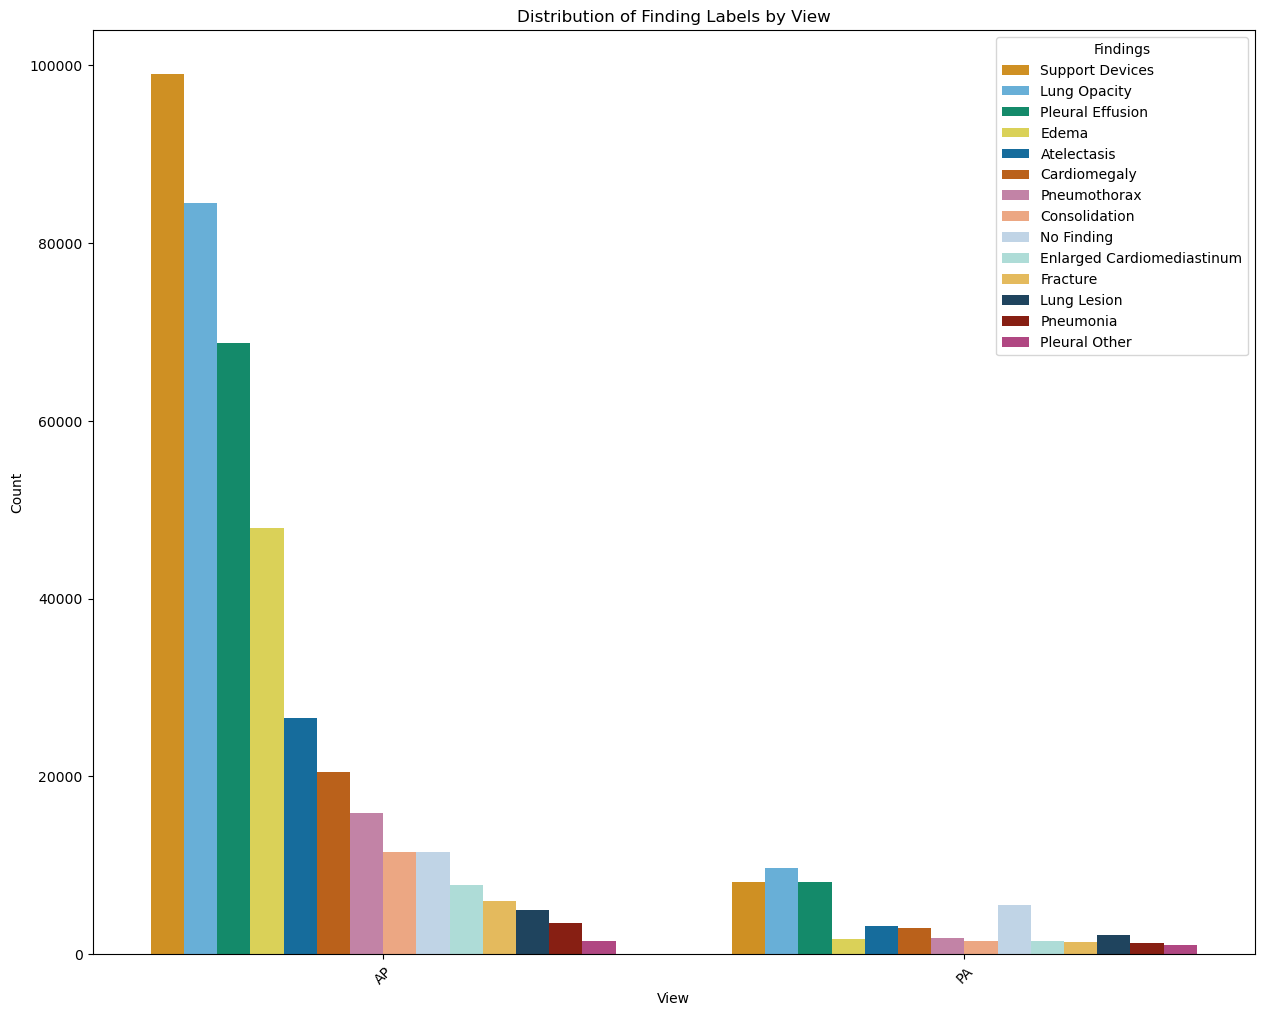

In [29]:
plot_multicol_aggregated_findings(d_chex_csv, columns_to_plot, 'view', 'Distribution of Finding Labels by View', expanded_colors)


Grouped Data
        Sex                     Finding  Count  group_order
40   Female             Support Devices  43087            0
10   Female                Lung Opacity  38878            0
31   Female            Pleural Effusion  31936            0
16   Female                       Edema  21064            0
25   Female                 Atelectasis  11857            0
7    Female                Cardiomegaly   9120            0
1    Female                  No Finding   7278            0
28   Female                Pneumothorax   6944            0
19   Female               Consolidation   5392            0
4    Female  Enlarged Cardiomediastinum   3436            0
13   Female                 Lung Lesion   3033            0
37   Female                    Fracture   2605            0
22   Female                   Pneumonia   1946            0
34   Female               Pleural Other    940            0
39     Male             Support Devices  64080            1
9      Male                

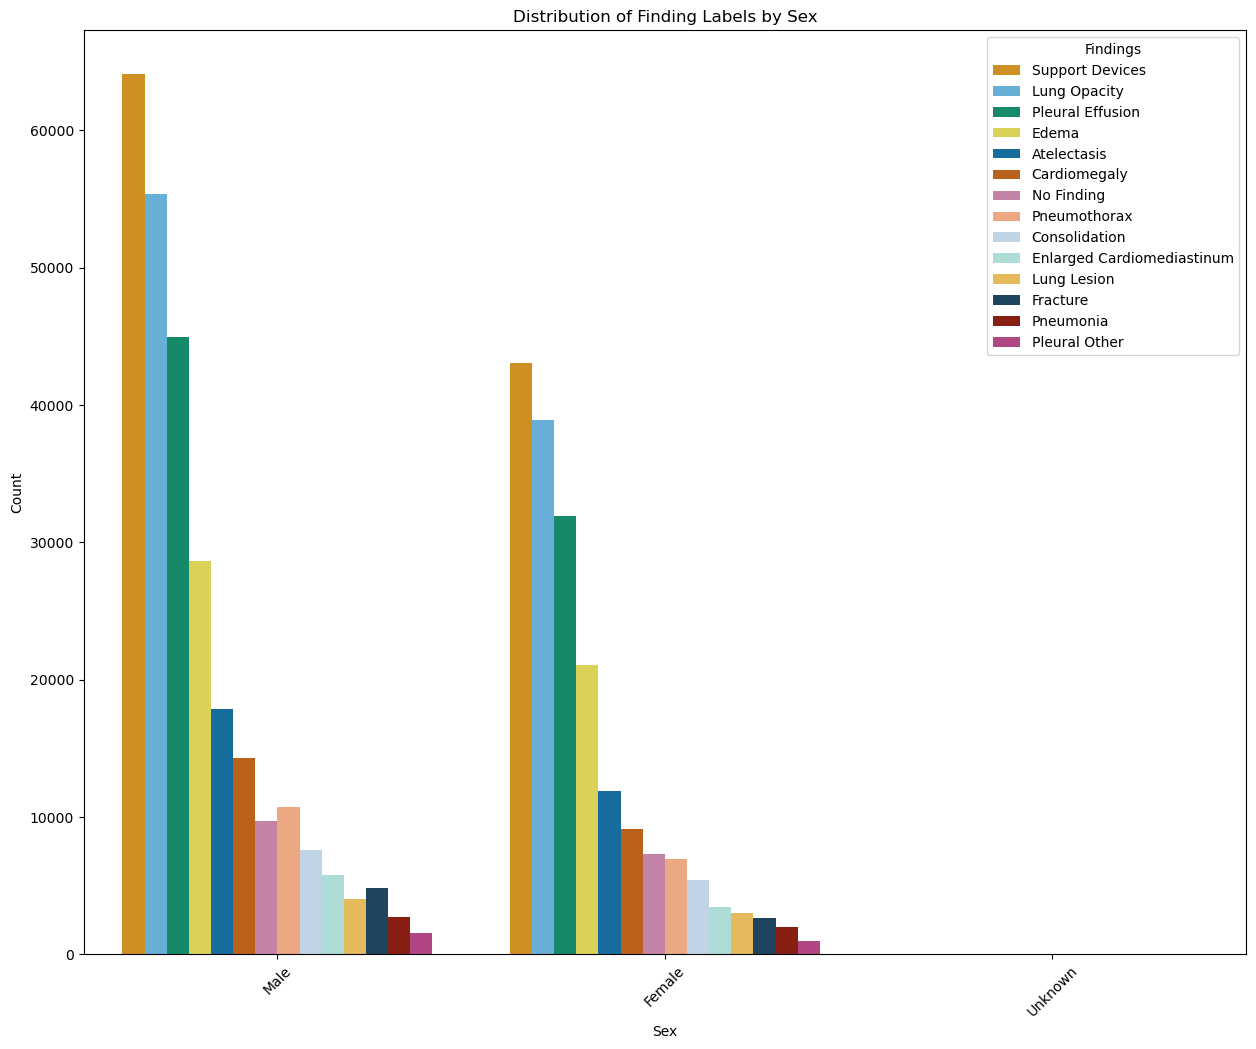

In [30]:
plot_multicol_aggregated_findings(d_chex_csv, columns_to_plot, 'Sex', 'Distribution of Finding Labels by Sex', expanded_colors)

Patient Gender
M    63340
F    48780
Name: count, dtype: int64
Patient Gender
M    63340
F    48780
Name: count, dtype: int64


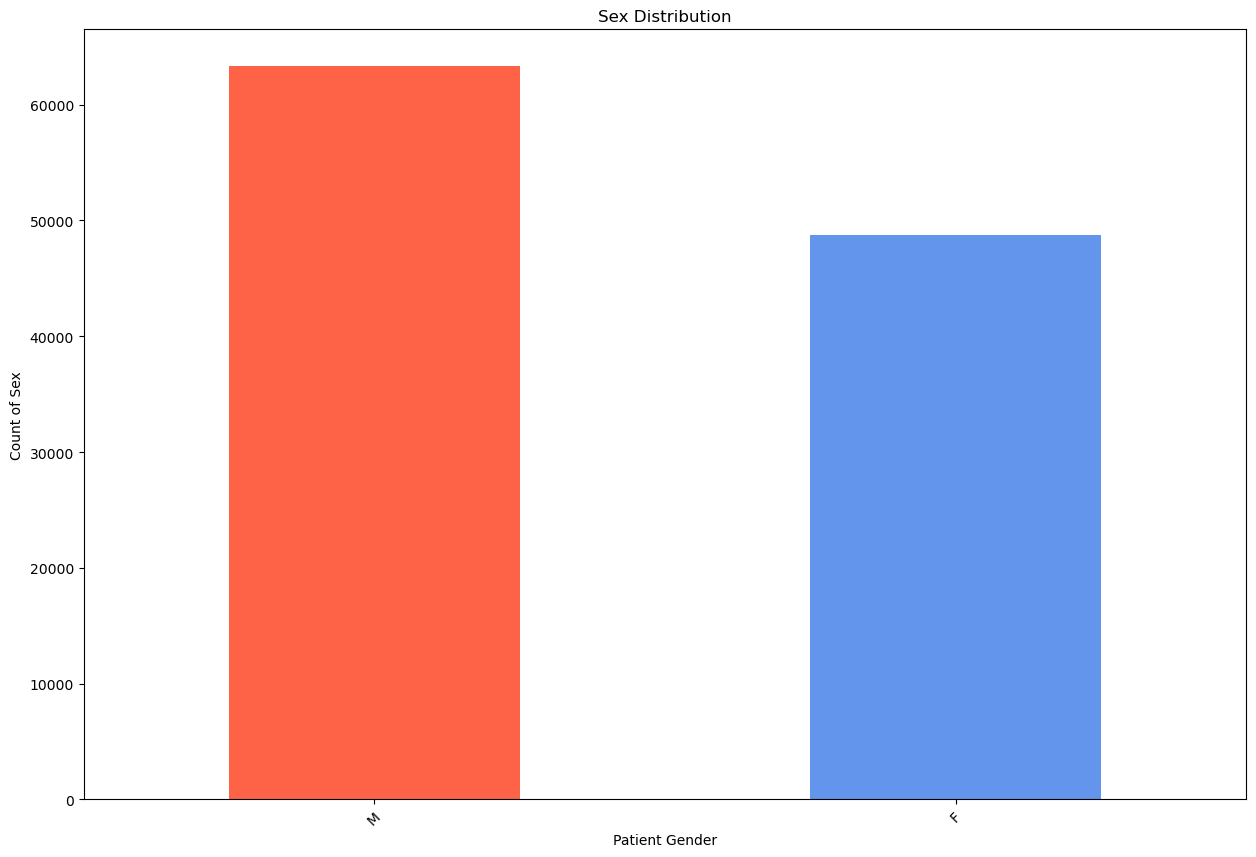

In [31]:
# Get sex count and plot
sex = d_nih_csv['Patient Gender'].value_counts()
print(sex)
create_plot(sex, 'Count of Sex', 'Sex Distribution')



view
PA    67310
AP    44810
Name: count, dtype: int64
view
PA    67310
AP    44810
Name: count, dtype: int64


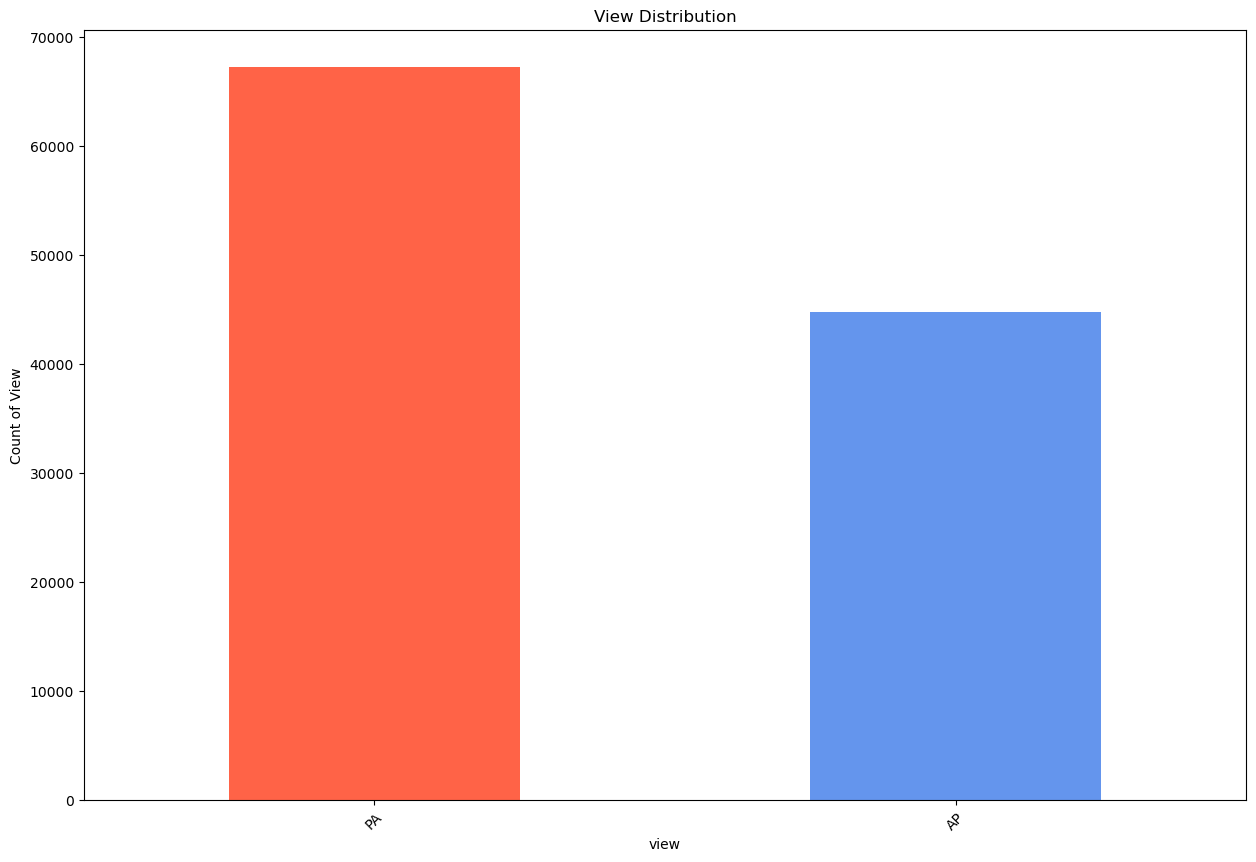

In [32]:
# Get view count and plot
view= d_nih_csv['view'].value_counts()
print(view)
create_plot(view, 'Count of View', 'View Distribution')

Patient Age
0      14
1      54
2      68
3      97
4     108
     ... 
91     11
92      6
93     11
94      3
95      1
Name: count, Length: 96, dtype: int64


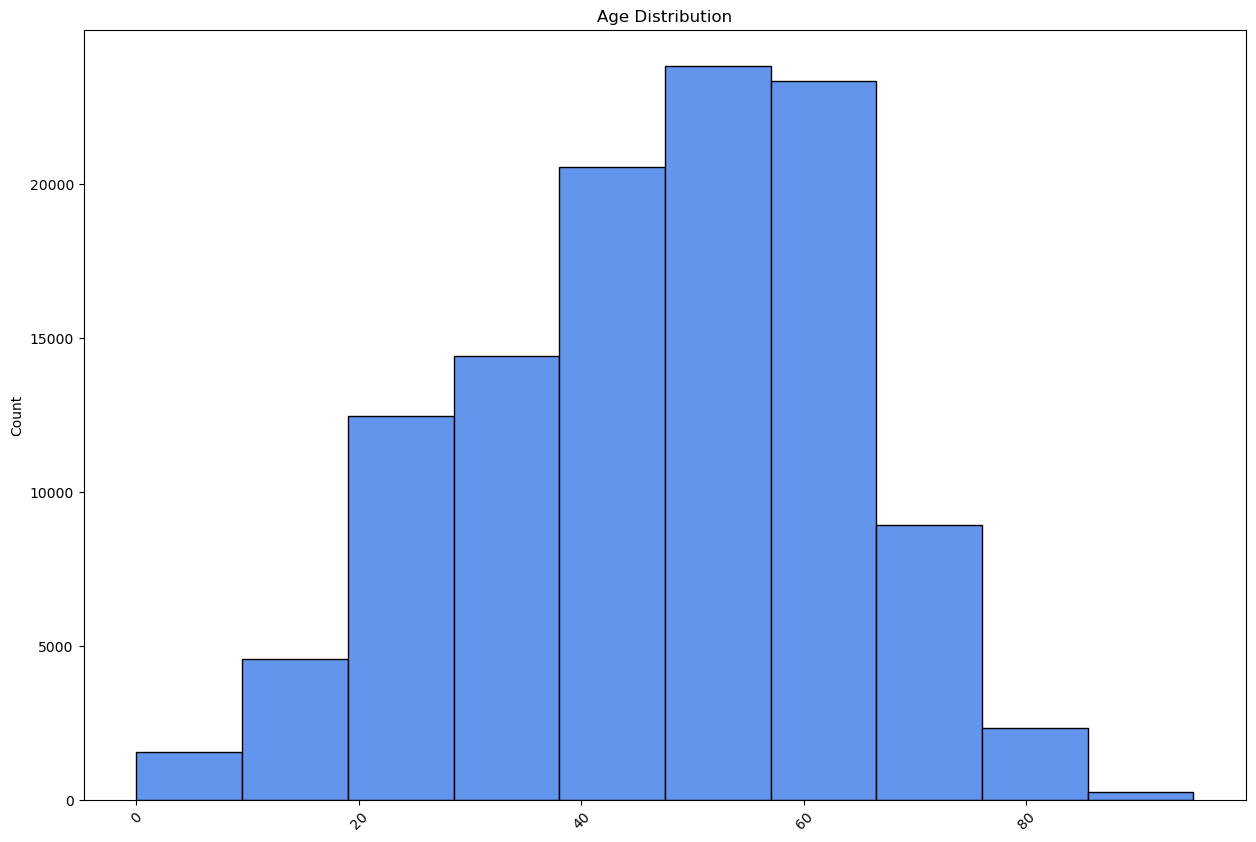

In [33]:
# Get age count and plot
age = d_nih_csv['Patient Age']
# Call the create_plot function to create a histogram of the age distribution
create_plot(age, y_label='Count', title='Age Distribution', kind='hist', color=['CornflowerBlue'])

Finding Labels
No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: count, dtype: int64


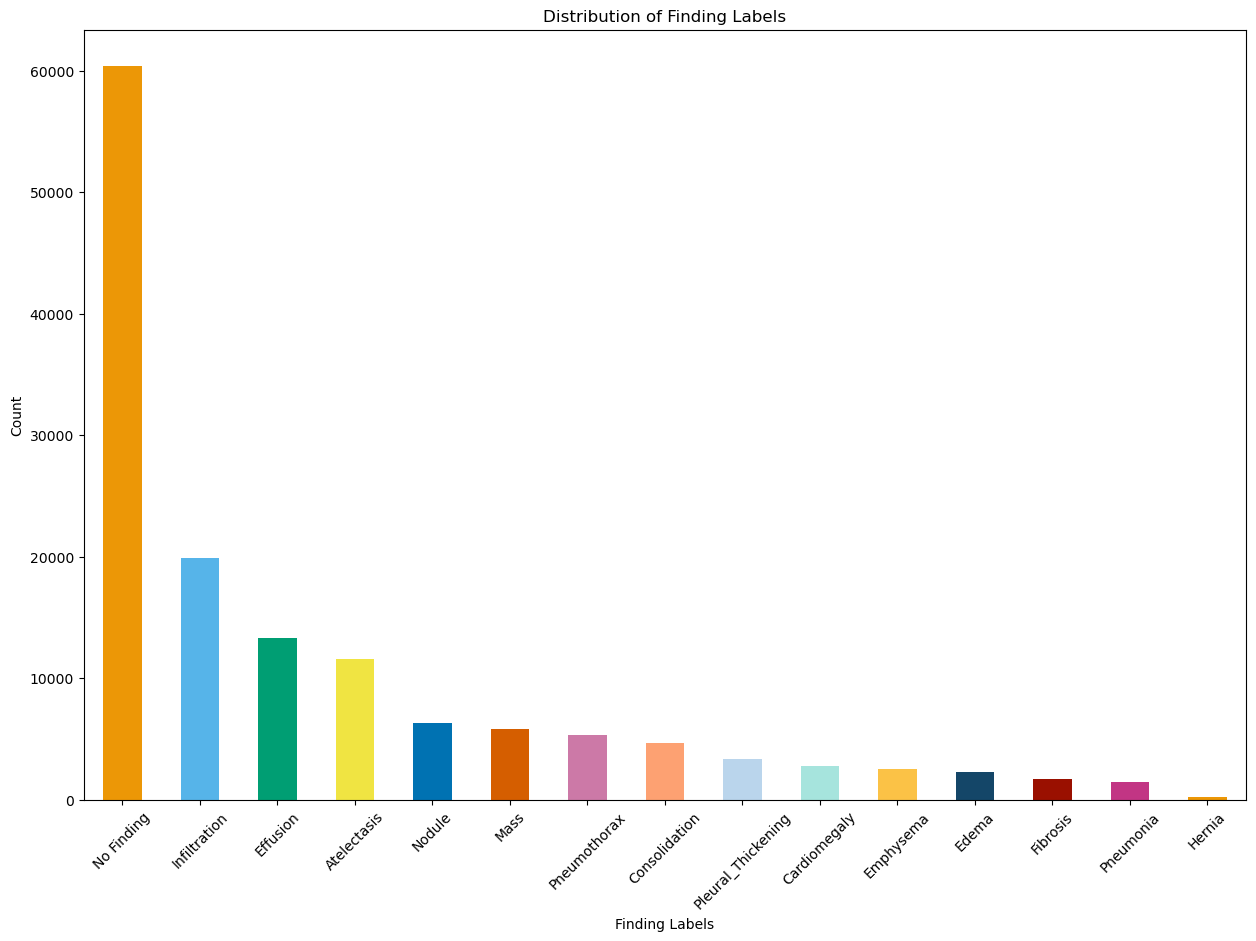

In [34]:
# Split the disease labels and count them
split_disease = d_nih_csv['Finding Labels'].str.split('|').explode().rename('Finding Labels')
disease = split_disease.value_counts()

create_plot(disease, y_label='Count', title='Distribution of Finding Labels', color=expanded_colors)

Finding Labels
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: count, dtype: int64


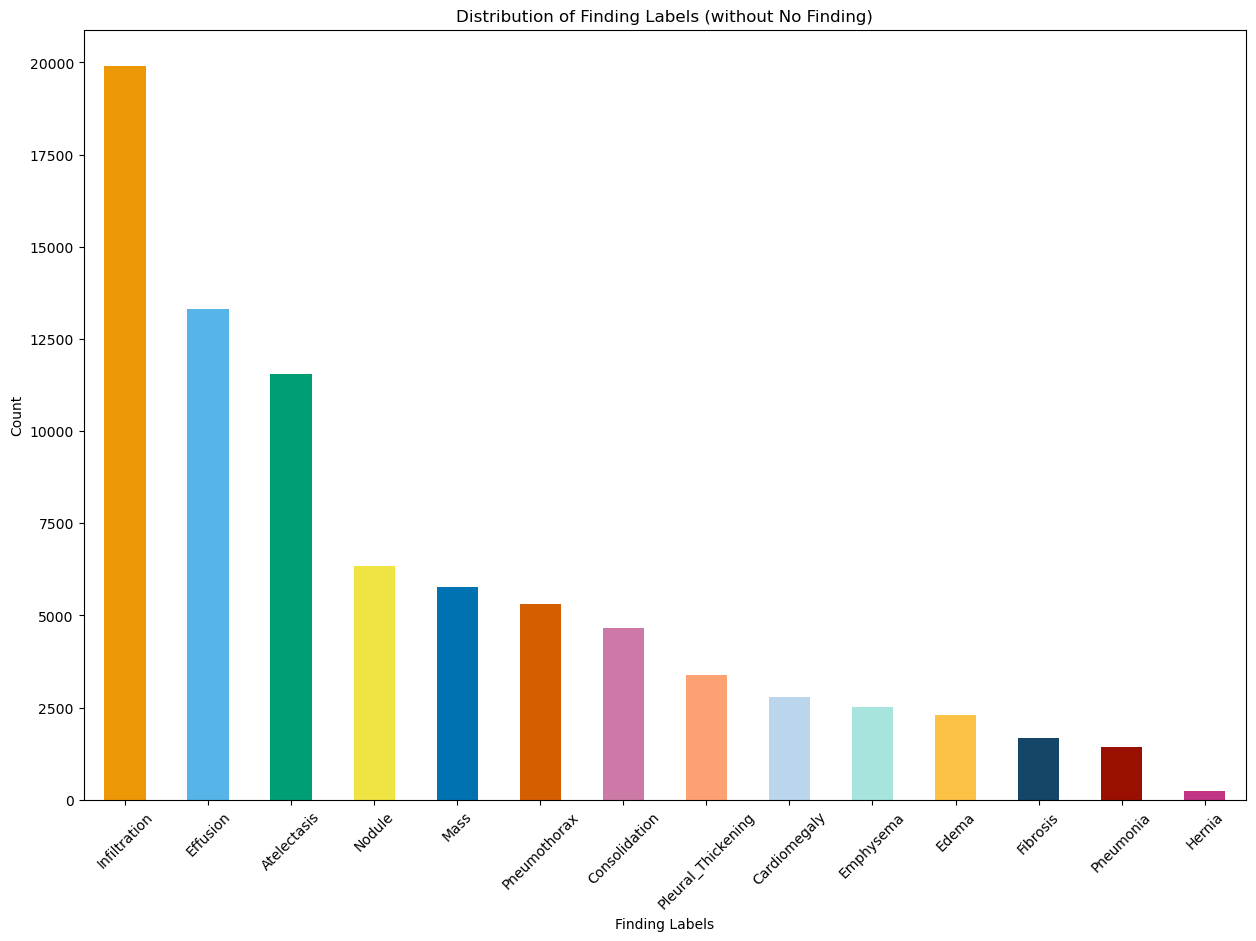

In [35]:
# Remove the "No Finding" label from the counts
disease_without_no_finding = disease[disease.index != 'No Finding']

create_plot(disease_without_no_finding, y_label='Count', title='Distribution of Finding Labels (without No Finding)', color=expanded_colors)


Patient Gender      F      M
view                        
AP              18613  26197
PA              30167  37143


<Figure size 1500x1000 with 0 Axes>

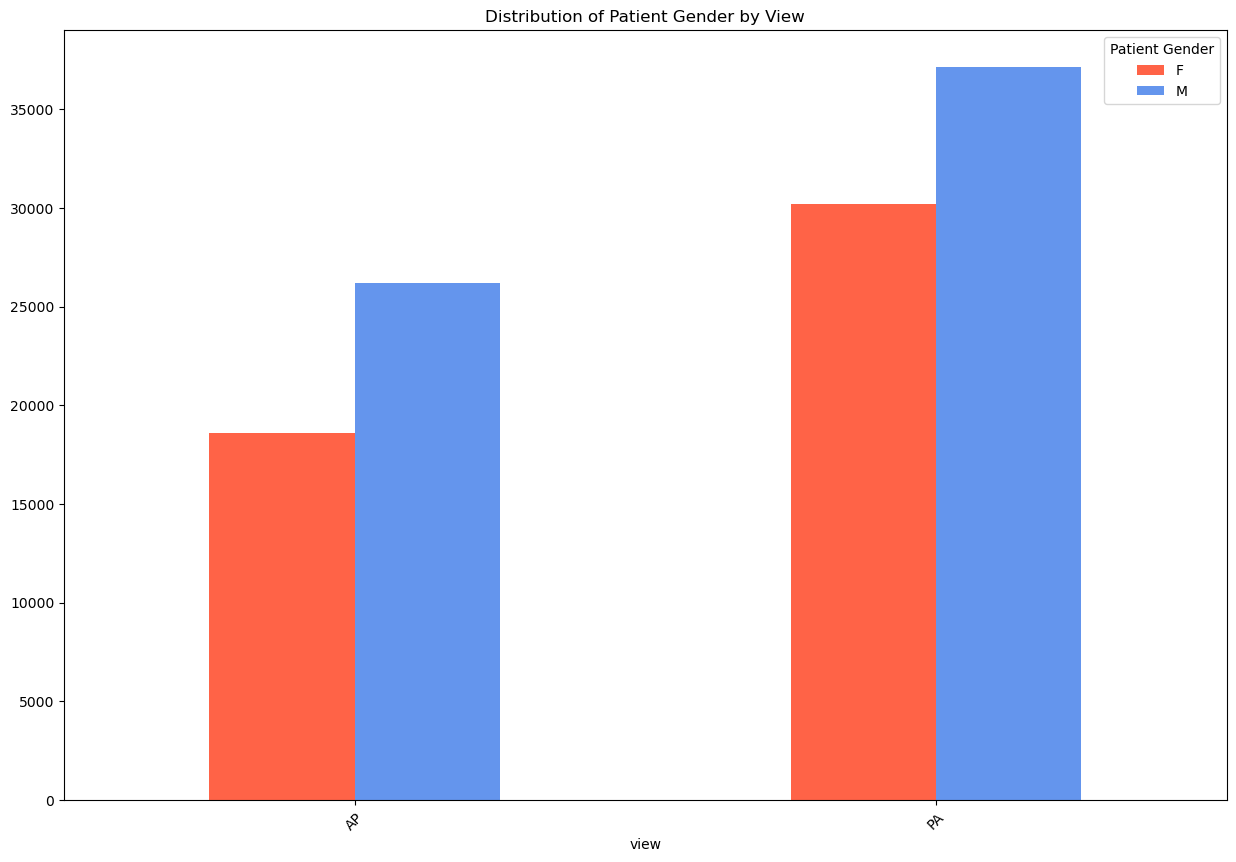

In [36]:
create_aggregated_plot(d_nih_csv, ['view', 'Patient Gender'], y_label='Count', title='Distribution of Patient Gender by View',color=['Tomato', 'CornflowerBlue', 'OliveDrab'])


Patient Gender age_group  Count
             M     50-60  15498
             F     50-60  11843
             M     40-50  11515
             M     60-70  11399
             F     40-50  10387
             M     30-40   8762
             F     30-40   7776
             M     20-30   7597
             F     60-70   7566
             F     20-30   5258
             M      0-20   4080
             M     70-80   3913
             F      0-20   2966
             F     70-80   2541
             M     80-90    545
             F     80-90    410
             F    90-100     33
             M    90-100     31


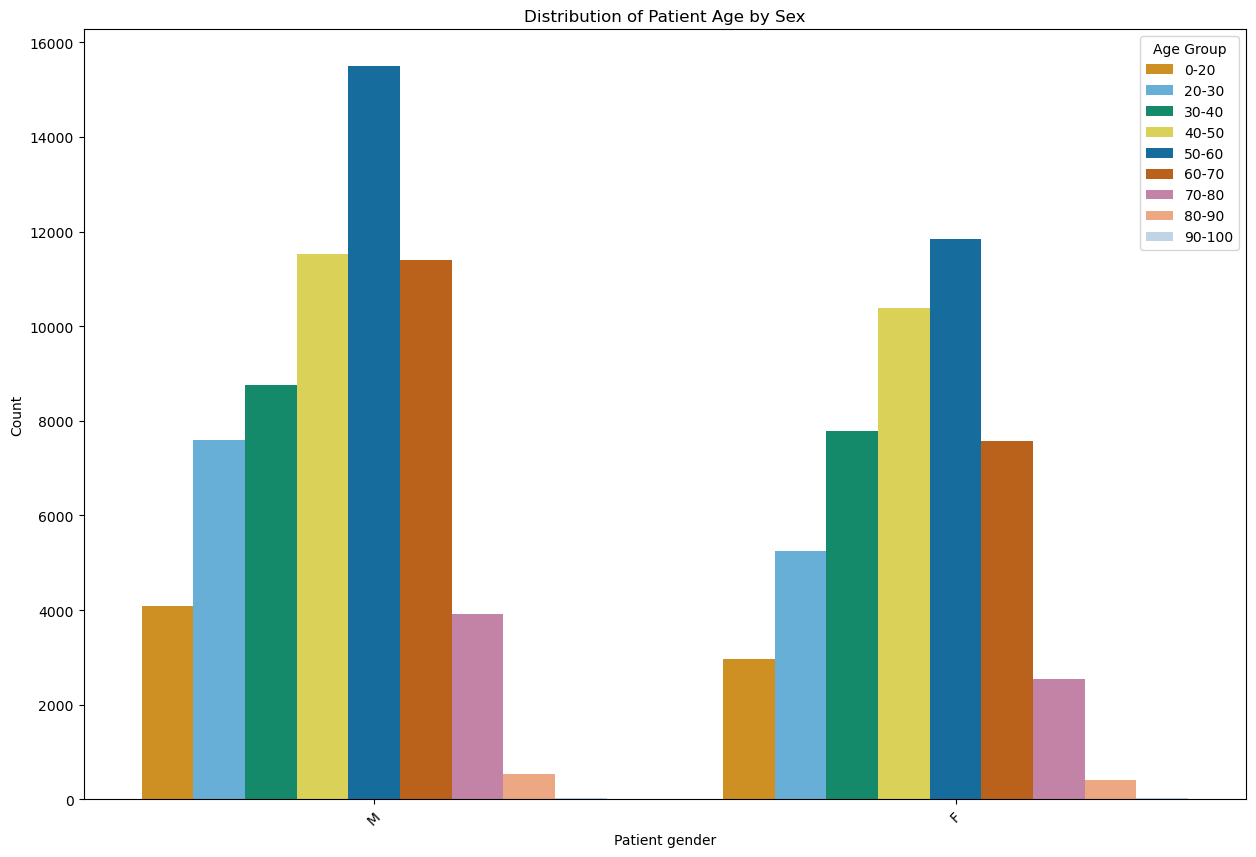

In [37]:
create_aggregated_plot(d_nih_csv, ['Patient Gender', 'Patient Age'], y_label='Age Group', title='Distribution of Patient Age by Sex', kind='hist',bins=age_bins, color=expanded_colors)

view age_group  Count
  PA     50-60  16526
  PA     40-50  13557
  PA     60-70  11678
  AP     50-60  10815
  PA     30-40  10066
  AP     40-50   8345
  PA     20-30   7293
  AP     60-70   7287
  AP     30-40   6472
  AP     20-30   5562
  PA     70-80   3907
  PA      0-20   3656
  AP      0-20   3390
  AP     70-80   2547
  PA     80-90    598
  AP     80-90    357
  AP    90-100     35
  PA    90-100     29


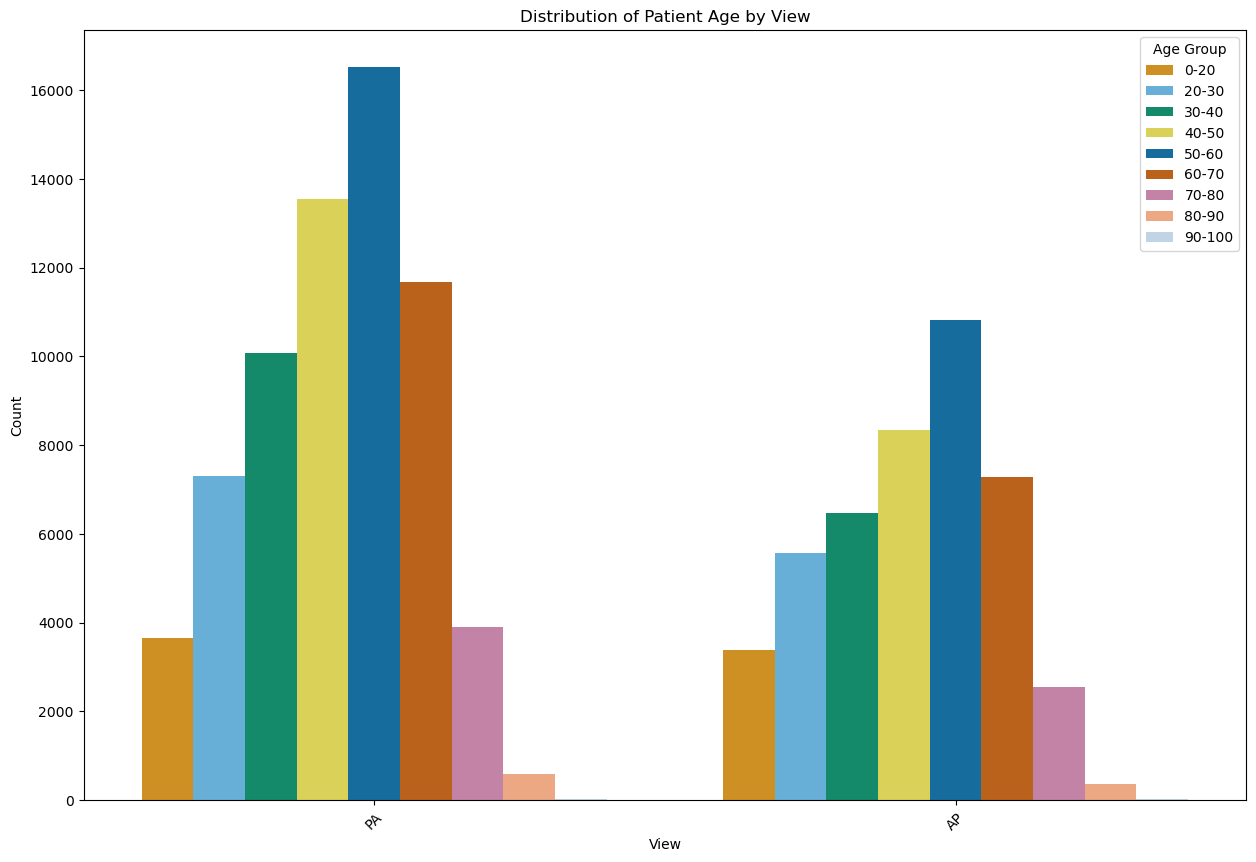

In [38]:
create_aggregated_plot(d_nih_csv, ['view', 'Patient Age'], y_label='Age Group', title='Distribution of Patient Age by View', kind='hist',bins=age_bins, color=expanded_colors)

In [39]:
# Split and explode 'Finding Labels', keeping the original index (d)
split_disease = d_nih_csv['Finding Labels'].str.split('|').explode().reset_index().rename(columns={'Finding Labels': 'Finding'})

# Join with necessary columns from the original DataFrame
split_disease = split_disease.join(d_nih_csv[['view', 'Patient Age', 'Patient Gender']], on='index')


In [40]:
# Split and explode 'Finding Labels', keeping the original index (d)
split_disease_removed = d_nih_csv['Finding Labels'].str.split('|').explode().reset_index().rename(columns={'Finding Labels': 'Finding'})

# Filter out rows with 'No Finding'
split_disease_removed = split_disease_removed[split_disease['Finding'] != 'No Finding']

# Join with necessary columns from the original DataFrame
split_disease_removed = split_disease_removed.join(d_nih_csv[['view', 'Patient Age', 'Patient Gender']], on='index')


           Finding age_group  Count
        No Finding     50-60  14179
        No Finding     40-50  12248
        No Finding     30-40   9611
        No Finding     60-70   9288
        No Finding     20-30   7425
      Infiltration     50-60   4636
        No Finding      0-20   4121
      Infiltration     40-50   3834
          Effusion     50-60   3550
      Infiltration     60-70   3288
       Atelectasis     50-60   3185
        No Finding     70-80   3051
      Infiltration     30-40   2925
          Effusion     60-70   2605
      Infiltration     20-30   2505
       Atelectasis     60-70   2413
          Effusion     40-50   2341
       Atelectasis     40-50   2221
            Nodule     50-60   1849
          Effusion     30-40   1742
              Mass     50-60   1591
      Infiltration      0-20   1397
       Atelectasis     30-40   1296
            Nodule     40-50   1283
            Nodule     60-70   1235
          Effusion     20-30   1221
      Pneumothorax     50-60

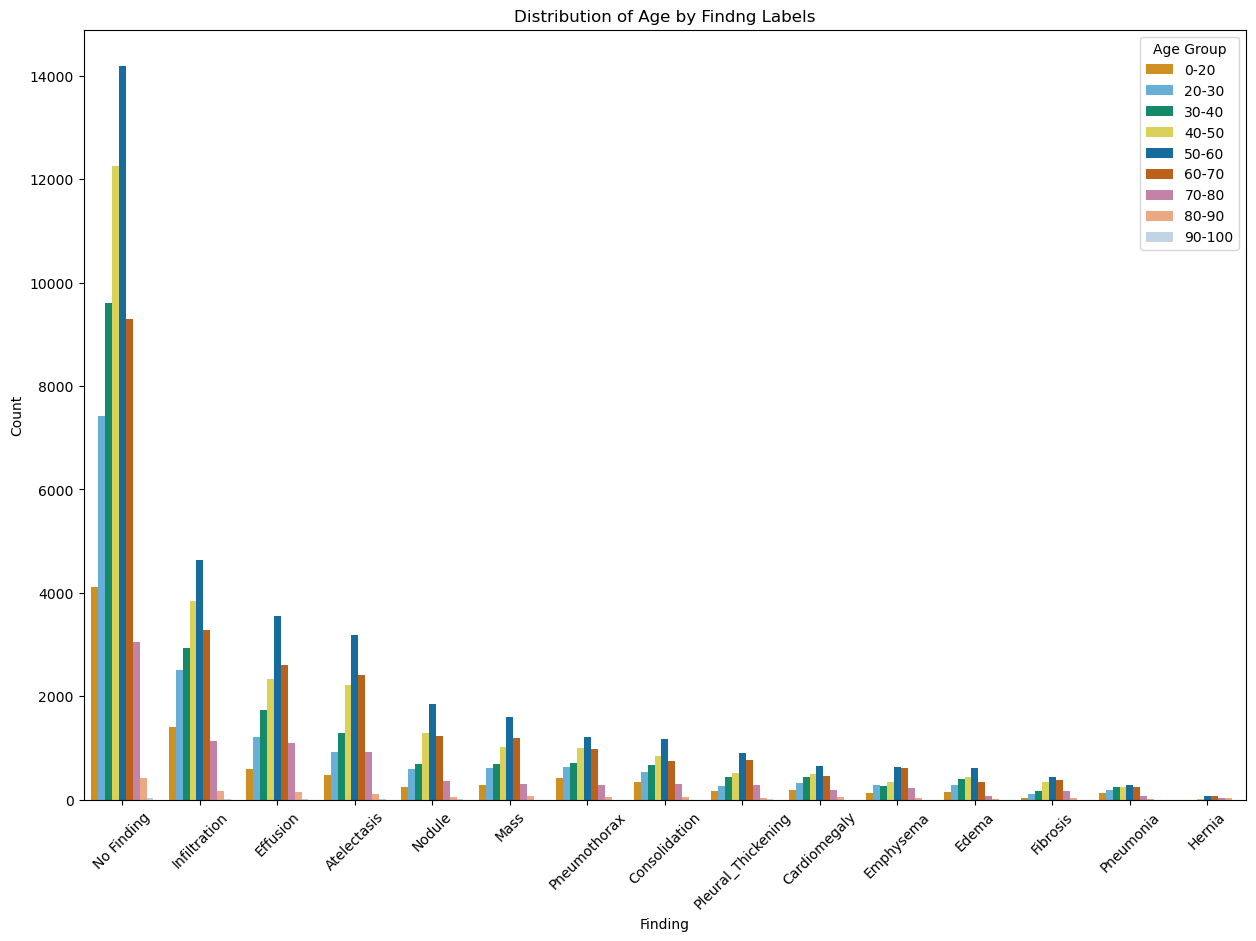

In [41]:
#Pass to create_aggregated_plot
create_aggregated_plot(split_disease, ['Finding','Patient Age'], y_label='Age Group', title='Distribution of Age by Findng Labels', kind='hist',bins=age_bins, color=expanded_colors)


           Finding age_group  Count
      Infiltration     50-60   4636
      Infiltration     40-50   3834
          Effusion     50-60   3550
      Infiltration     60-70   3288
       Atelectasis     50-60   3185
      Infiltration     30-40   2925
          Effusion     60-70   2605
      Infiltration     20-30   2505
       Atelectasis     60-70   2413
          Effusion     40-50   2341
       Atelectasis     40-50   2221
            Nodule     50-60   1849
          Effusion     30-40   1742
              Mass     50-60   1591
      Infiltration      0-20   1397
       Atelectasis     30-40   1296
            Nodule     40-50   1283
            Nodule     60-70   1235
          Effusion     20-30   1221
      Pneumothorax     50-60   1210
              Mass     60-70   1190
     Consolidation     50-60   1170
      Infiltration     70-80   1130
          Effusion     70-80   1091
              Mass     40-50   1026
      Pneumothorax     40-50   1007
      Pneumothorax     60-70

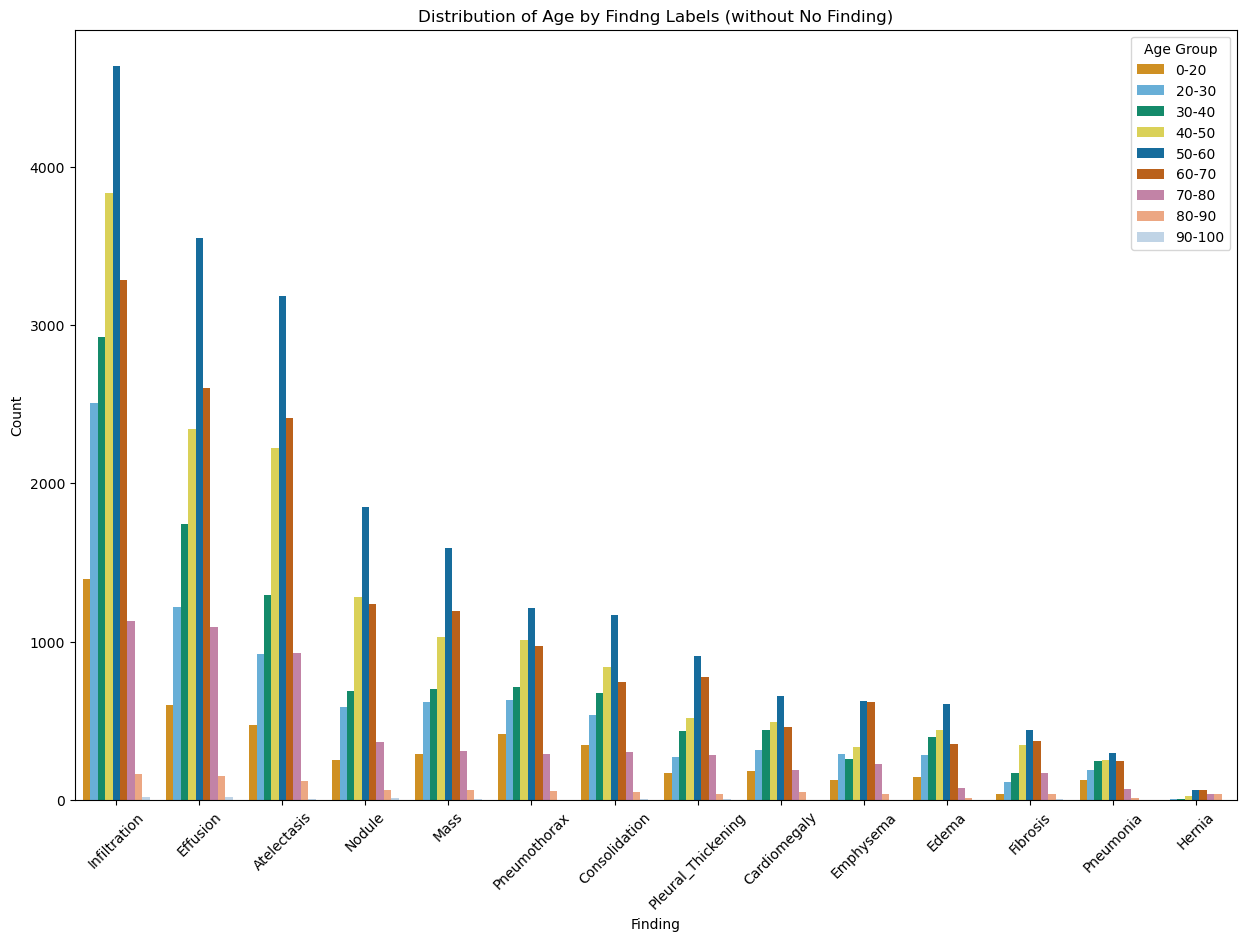

In [42]:
#Pass to create_aggregated_plot
create_aggregated_plot(split_disease_removed, ['Finding','Patient Age'], y_label='Age Group', title='Distribution of Age by Findng Labels (without No Finding)', kind='hist',bins=age_bins, color=expanded_colors)


Finding  Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax
view                                                                                                                                                                                
AP              5831          1213           3146   2027      6728       1017       278      35         10541  2215       21059    2154                 967        801          1895
PA              5728          1563           1521    276      6589       1499      1408     192          9353  3567       39302    4177                2418        630          3407


<Figure size 1500x1000 with 0 Axes>

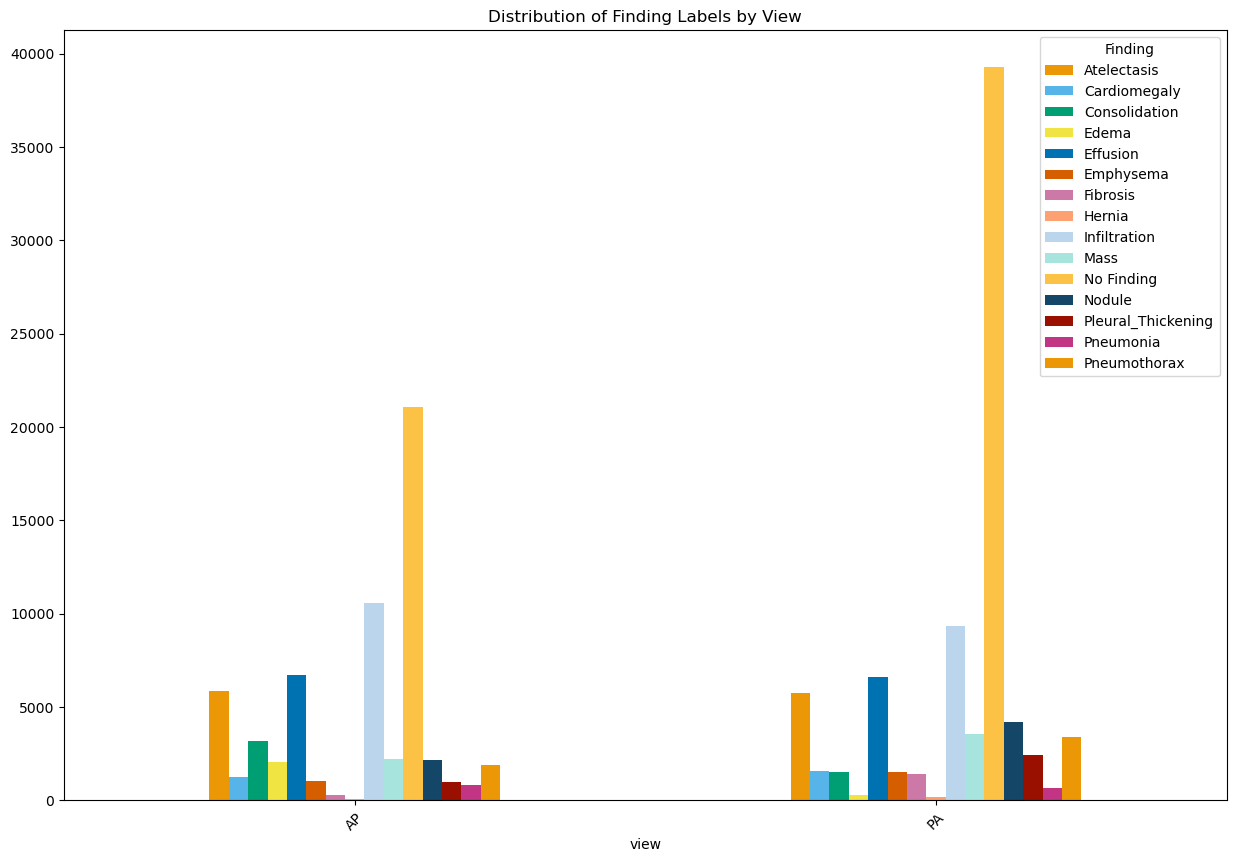

In [43]:
create_aggregated_plot(split_disease, ['view', 'Finding'], y_label='Count', title='Distribution of Finding Labels by View', color=expanded_colors)


Finding  Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax
view                                                                                                                                                                    
AP              5831          1213           3146   2027      6728       1017       278      35         10541  2215    2154                 967        801          1895
PA              5728          1563           1521    276      6589       1499      1408     192          9353  3567    4177                2418        630          3407


<Figure size 1500x1000 with 0 Axes>

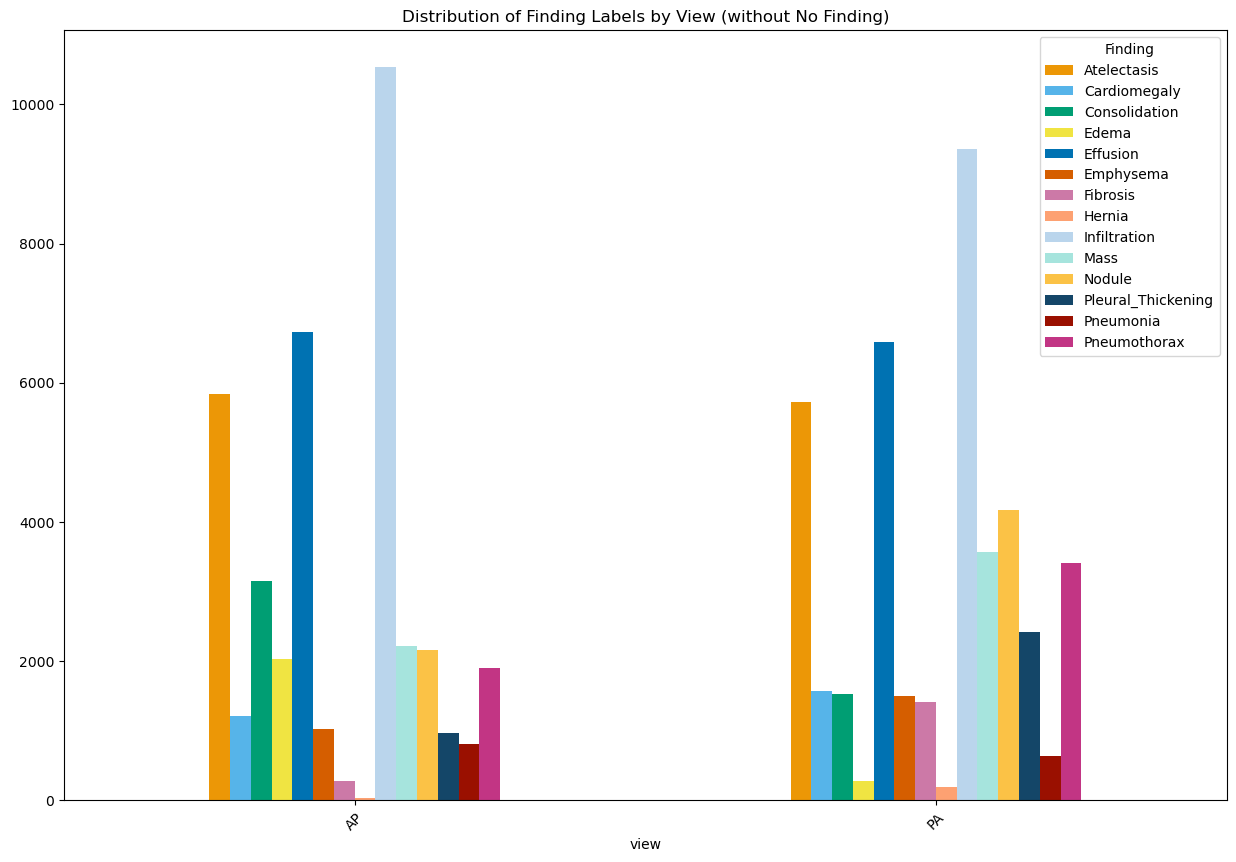

In [44]:
create_aggregated_plot(split_disease_removed, ['view', 'Finding'], y_label='Count', title='Distribution of Finding Labels by View (without No Finding)', color=expanded_colors)


Finding         Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax
Patient Gender                                                                                                                                                                             
F                      4653          1469           2001   1099      5882        906       771     131          8467  2253       26439    2646                1343        593          2585
M                      6906          1307           2666   1204      7435       1610       915      96         11427  3529       33922    3685                2042        838          2717


<Figure size 1500x1000 with 0 Axes>

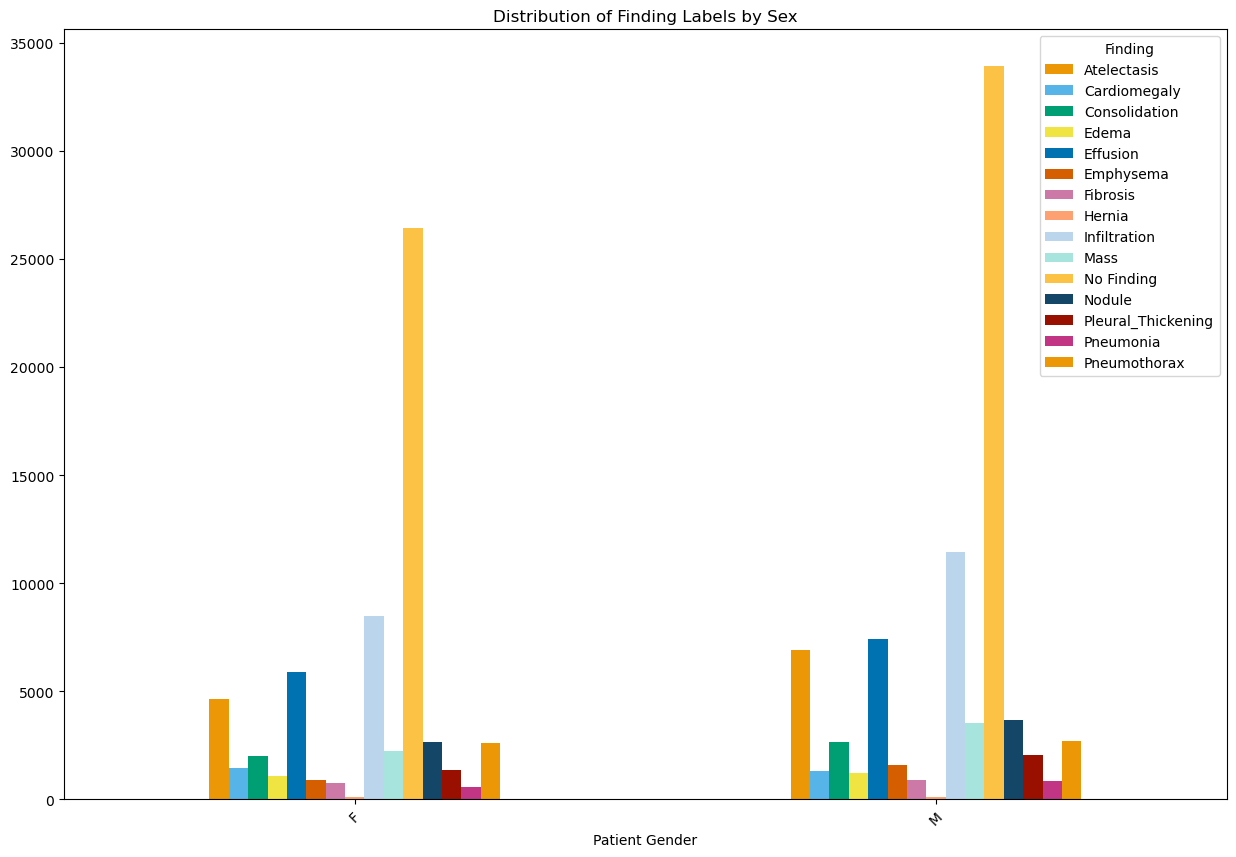

In [45]:
create_aggregated_plot(split_disease, ['Patient Gender', 'Finding'], y_label='Count', title='Distribution of Finding Labels by Sex', color=expanded_colors)

Finding         Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax
Patient Gender                                                                                                                                                                 
F                      4653          1469           2001   1099      5882        906       771     131          8467  2253    2646                1343        593          2585
M                      6906          1307           2666   1204      7435       1610       915      96         11427  3529    3685                2042        838          2717


<Figure size 1500x1000 with 0 Axes>

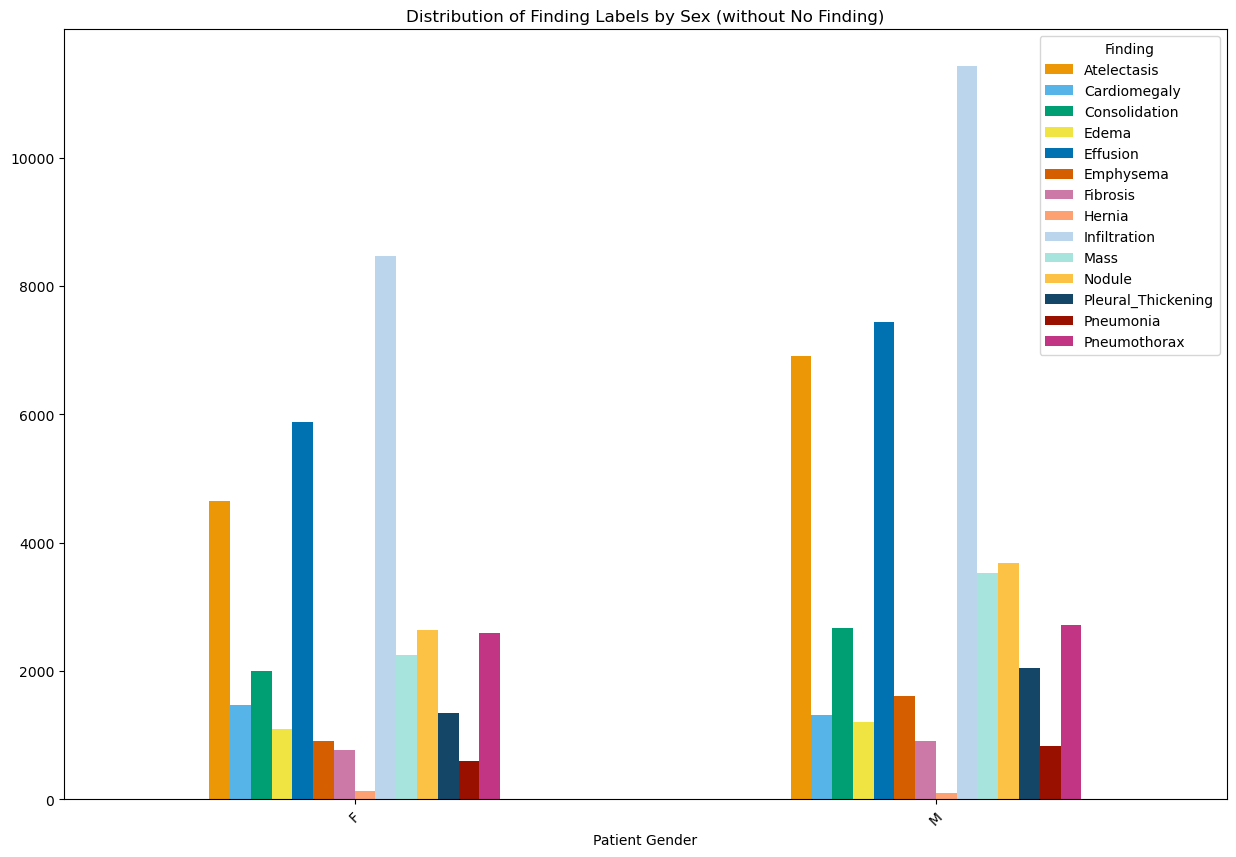

In [46]:
create_aggregated_plot(split_disease_removed, ['Patient Gender', 'Finding'], y_label='Count', title='Distribution of Finding Labels by Sex (without No Finding)', color=expanded_colors)

<Axes: xlabel='view'>

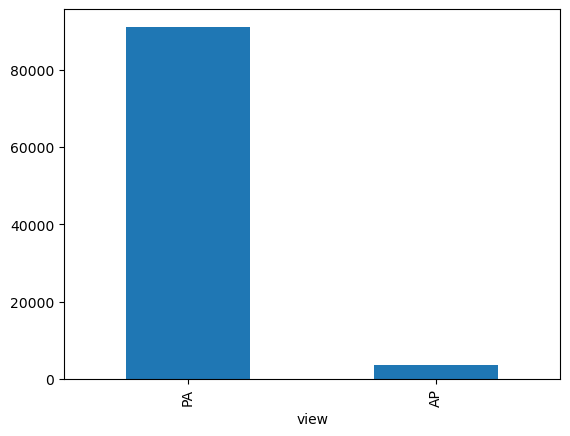

In [47]:
#Getting Included Pathologies
totals = d_pad.totals()
pathologies = []
for p in totals:
    pathologies.append(p)
pathologies.append('normal')
pathologies.append('pleural effusion')

#Plot of total view count
d_views = d_pad.csv['view'].value_counts().plot(kind="bar")
d_views


Text(0.5, 1.0, 'Gender Distribution Across Dataset')

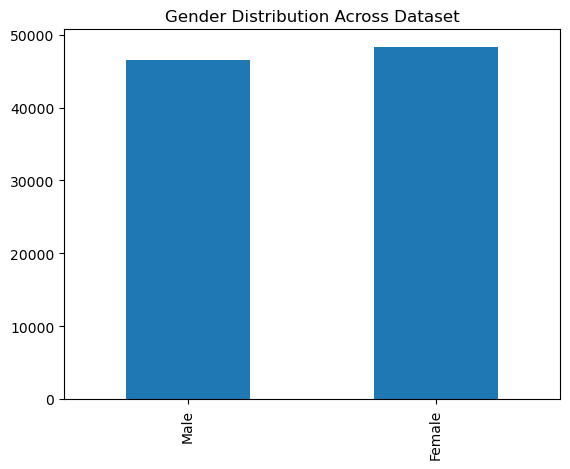

In [48]:

#Plot of total gender distribution
d_genders = pd.concat([d_pad.csv['sex_male'], d_pad.csv['sex_female']], axis=1)
d_genders = d_genders.rename(columns={"sex_male": "Male", "sex_female": "Female"})
genders_sum = d_genders.sum()
genders_sum

gender_plot = genders_sum.plot(kind="bar")
gender_plot.set_title("Gender Distribution Across Dataset")


In [49]:
d_pad.csv["Labels"].head()

0                                           ['normal']
2    ['pulmonary fibrosis', 'chronic changes', 'kyp...
3                                  ['chronic changes']
5    ['unchanged', 'alveolar pattern', 'interstitia...
7    ['laminar atelectasis', 'pleural effusion', 'a...
Name: Labels, dtype: object

view
PA    91170
AP     3655
Name: count, dtype: int64


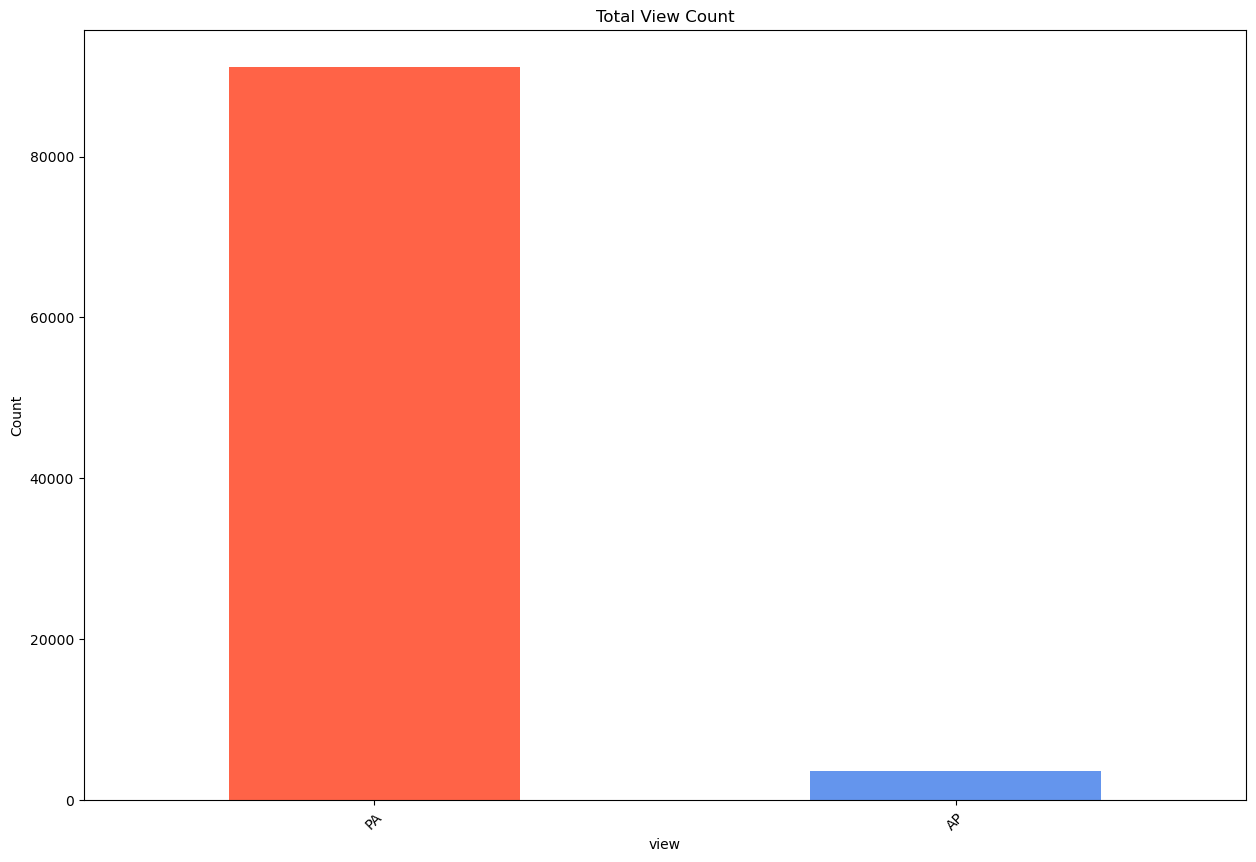

In [50]:
create_plot(d_pad.csv['view'].value_counts(), y_label='Count', title='Total View Count', kind='bar')

Female    48308
Male      46504
dtype: int64


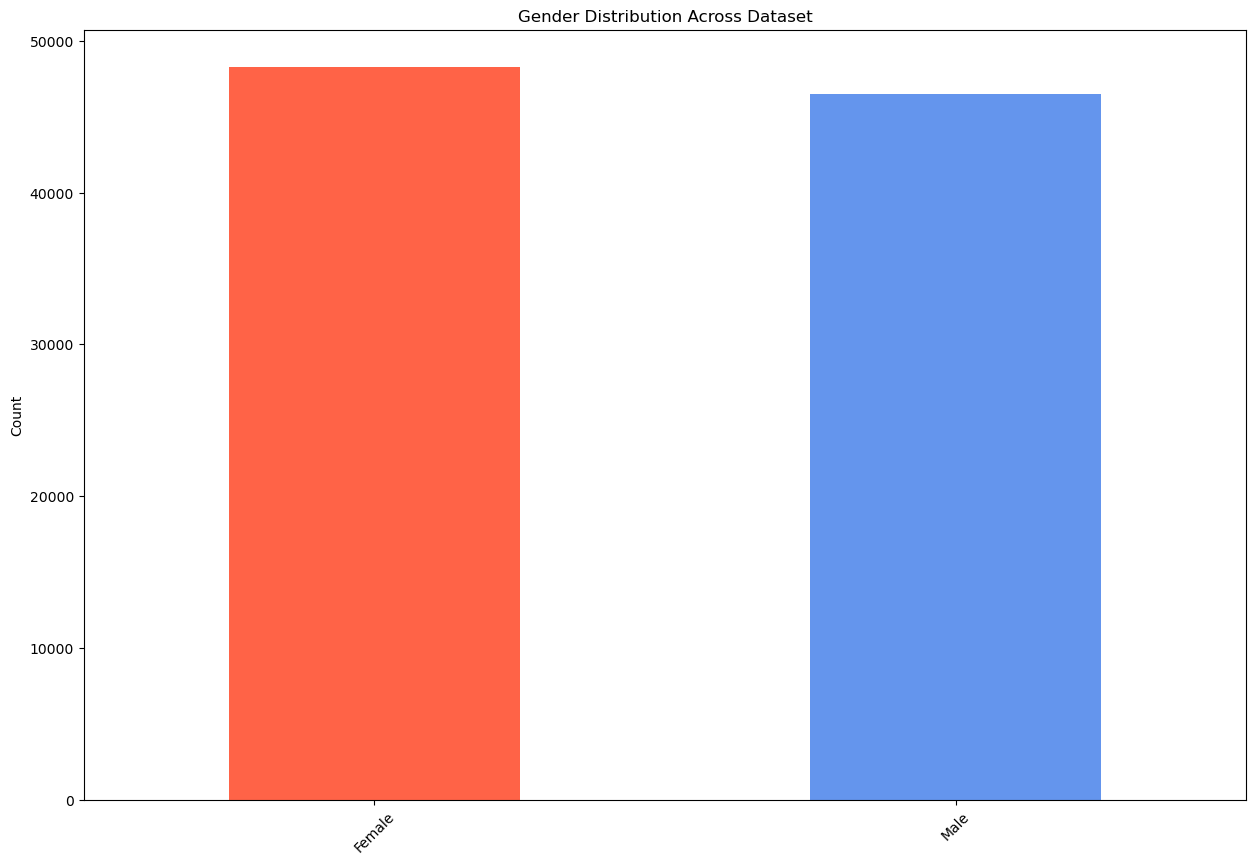

In [51]:
d_genders = pd.concat([d_pad.csv['sex_male'], d_pad.csv['sex_female']], axis=1)
d_genders = d_genders.rename(columns={"sex_male": "Male", "sex_female": "Female"})
create_plot(d_genders.sum(), y_label='Count', title='Gender Distribution Across Dataset', kind='bar')

Labels
normal                         34543
cardiomegaly                    8443
aortic elongation               6860
scoliosis                       5166
costophrenic angle blunting     3407
air trapping                    2782
pleural effusion                2558
nodule                          1914
aortic atheromatosis            1631
pneumonia                       1540
bronchiectasis                  1447
hemidiaphragm elevation         1282
atelectasis                     1050
consolidation                    957
hilar enlargement                858
granuloma                        435
emphysema                        424
pneumothorax                     206
flattened diaphragm              196
tuberculosis                      76
mass                              21
fracture                           9
Name: count, dtype: int64


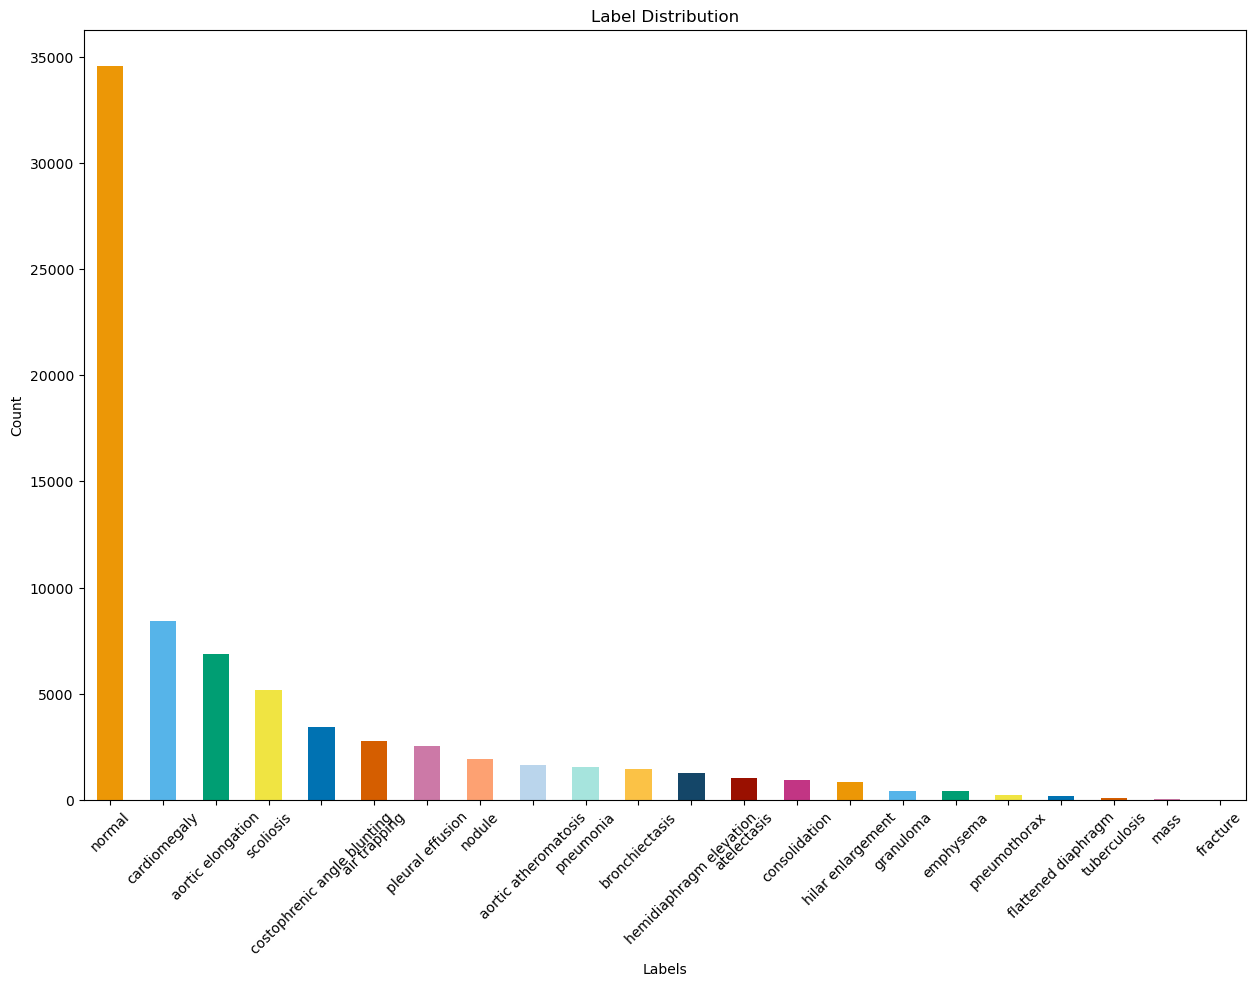

In [52]:
# Prepare label data
d_labelData = pd.concat([d_pad.csv["Labels"], d_pad.csv["sex_male"], d_pad.csv["Projection"]], axis=1)
d_labelData["Labels"] = d_labelData["Labels"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Explode the 'Labels' column
d_labelData = d_labelData.explode("Labels")

# Filter out labels which aren't included in pathologies
d_labelData = d_labelData[d_labelData["Labels"].apply(lambda x: any(label.lower() == x.lower() for label in pathologies))]

# Plot label distribution
create_plot(d_labelData['Labels'].value_counts(), y_label='Count', title='Label Distribution', kind='bar', color=expanded_colors)

Projection                    AP     PA
Labels                                 
air trapping                  18   2764
aortic atheromatosis          48   1583
aortic elongation            119   6741
atelectasis                  248    802
bronchiectasis                16   1431
cardiomegaly                 318   8125
consolidation                106    851
costophrenic angle blunting  101   3306
emphysema                     10    414
flattened diaphragm            0    196
fracture                       0      9
granuloma                      2    433
hemidiaphragm elevation       52   1230
hilar enlargement             26    832
mass                           1     20
nodule                        71   1843
normal                       474  34069
pleural effusion             264   2294
pneumonia                    106   1434
pneumothorax                  16    190
scoliosis                     73   5093
tuberculosis                   0     76


<Figure size 1500x1000 with 0 Axes>

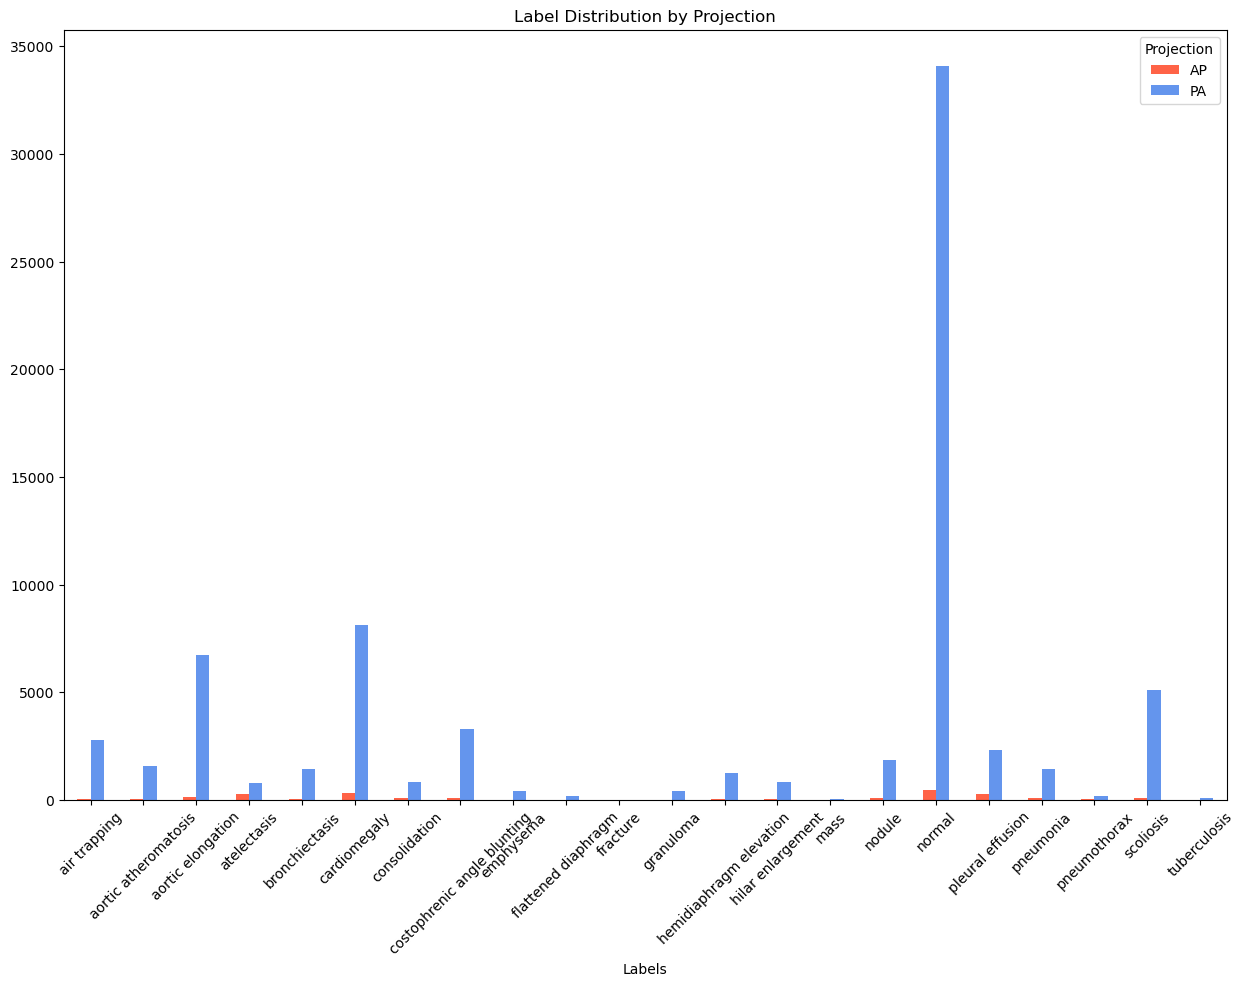

In [53]:

# Plotting using create_aggregated_plot
create_aggregated_plot(d_labelData, columns=['Labels', 'Projection'], y_label='Count', title='Label Distribution by Projection', kind='bar')


In [54]:
d_pad.csv

,Unnamed: 0,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,...,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS,view,offset_day_int,patientid,age_years,sex_male,sex_female
0,0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,...,[],"[['normal'], ['normal']]",[],[],PA,16328,839860488694292331637988235681460987,87.0,False,True
2,2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,...,"['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378'],PA,16692,313572750430997347502932654319389875966,88.0,True,False
3,3,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,POSTEROANTERIOR,PA,...,"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151'],PA,16633,50783093527901818115346441867348318648,92.0,False,True
5,5,313903302629300007485735352869488750471_75sg0k...,0,20170125,313903302629300007485735352869488750471,3707275269754751392247446521222810702,1978.0,M,NaN,AP,...,"['loc basal', 'loc left']","[['unchanged'], ['alveolar pattern', 'intersti...",['C1332240' 'C2073538'],['C1282378' 'C0443246'],AP,17191,3707275269754751392247446521222810702,39.0,True,False
7,7,3137231742710829928-247610802266403640553_kine...,0,20150804,3137231742710829928-247610802266403640553,93535126770783451980359712286922420997,1957.0,M,NaN,PA,...,"['loc basal', 'loc subsegmental', 'loc pleural...","[['laminar atelectasis', 'loc subsegmental', '...",['C2073625' 'C4305366' 'C0185792'],['C1282378' 'C0929165' 'C0032225' 'C0444532' '...,PA,16651,93535126770783451980359712286922420997,60.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160852,160852,1284011361929414522079841201696751542351444145...,49,20090714,1284011361929414522079841201696751542351444145...,178941107688363238116741298870229076976,1958.0,F,POSTEROANTERIOR,PA,...,[],"['exclude', 'normal', 'normal']",[],[],PA,14439,178941107688363238116741298870229076976,59.0,False,True
160856,160856,1284011361929414522814654121696751542351444145...,49,20110321,1284011361929414522814654121696751542351444145...,112930952416074060371371014599496493673,1948.0,M,POSTEROANTERIOR,PA,...,['loc costophrenic angle'],"['COPD signs', 'costophrenic angle blunting', ...",['C0024117' 'C0742855'],['C0230151'],PA,15054,112930952416074060371371014599496493673,69.0,True,False
160857,160857,1284011361929414522094646571696751542351444145...,49,20090609,1284011361929414522094646571696751542351444145...,282743729971423358706056731890510600934,1944.0,F,POSTEROANTERIOR,PA,...,[],['normal'],[],[],PA,14404,282743729971423358706056731890510600934,73.0,False,True
160859,160859,1284011361929414522084108901696751542351444145...,49,20101214,1284011361929414522084108901696751542351444145...,228646130593152933811948996634154201216,1943.0,F,POSTEROANTERIOR,PA,...,[],['normal'],[],[],PA,14957,228646130593152933811948996634154201216,74.0,False,True


In [55]:
d_nih.csv

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],view,has_masks,patientid,age_years,sex_male,sex_female
0,0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,PA,False,1,57.0,True,False
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,PA,False,1,58.0,True,False
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,PA,False,1,58.0,True,False
3,3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,PA,False,2,80.0,True,False
4,4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,PA,False,3,74.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168,PA,False,30801,38.0,True,False
112116,112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,PA,False,30802,28.0,True,False
112117,112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,PA,False,30803,42.0,False,True
112118,112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,PA,False,30804,29.0,False,True


In [56]:
d_chex.csv

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,view,patientid,age_years,sex_male,sex_female
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68.0,Frontal,AP,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,AP,00001,68.0,False,True
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87.0,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,1.0,NaN,AP,00002,87.0,False,True
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83.0,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,AP,00002,83.0,False,True
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41.0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,AP,00003,41.0,True,False
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20.0,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,PA,00004,20.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59.0,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,0.0,1.0,NaN,NaN,NaN,AP,64537,59.0,True,False
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59.0,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,NaN,-1.0,NaN,NaN,NaN,AP,64537,59.0,True,False
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,NaN,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,AP,64538,0.0,False,True
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,NaN,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,0.0,NaN,NaN,NaN,0.0,AP,64539,0.0,False,True


In [57]:
d_mimic.csv

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,view,offset_day_int,patientid
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect,PA,21800506,10000032
2,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect,PA,21800626,10000032
4,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN,AP,21800723,10000032
5,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect,AP,21800723,10000032
6,10000032,56699142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),antero-posterior,NaN,AP,21800805,10000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377089,19999733,57132437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3056,2544,21520708,224550.171,CHEST (PA AND LAT),postero-anterior,Erect,PA,21520708,19999733
377090,19999733,57132437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3056,2544,21520708,224550.171,CHEST (PA AND LAT),postero-anterior,Erect,PA,21520708,19999733
377092,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,...,2544,3056,21451104,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect,AP,21451104,19999987
377093,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3056,2544,21451102,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect,AP,21451102,19999987


In [58]:
# Updated function for unique patients per dataset with summary counts
def process_and_save_unique_patients_summary(datasets, dataset_names):
    """
    Process datasets to extract unique PatientID and Dataset associations,
    and append total counts at the end of the CSV file.
    """
    # Initialize an empty list to store individual DataFrames
    processed_data = []

    # Loop through each dataset and extract PatientID and Dataset
    for dataset, name in zip(datasets, dataset_names):
        # Ensure the dataset has the expected attributes
        if not hasattr(dataset, 'csv'):
            raise ValueError(f"Dataset {name} does not have a 'csv' attribute.")
        
        # Extract the relevant data
        df = dataset.csv  # Access the CSV DataFrame
        if 'patientid' not in df.columns:
            raise ValueError(f"Dataset {name} does not contain a 'PatientID' column.")
        
        # Add a Dataset column
        df['Dataset'] = name
        
        # Append to the list
        processed_data.append(df[['patientid', 'Dataset']])

    # Combine all datasets into one DataFrame
    combined_df = pd.concat(processed_data, ignore_index=True)
    
    # Drop duplicates to get unique patient-dataset combinations
    unique_patients = combined_df.drop_duplicates()

    # Count unique patients per dataset
    patient_counts = unique_patients['Dataset'].value_counts().reset_index()
    patient_counts.columns = ['Dataset', 'UniquePatientCount']
    
    # Prepare a summary DataFrame for totals
    summary_df = pd.DataFrame({
        'patientid': ['Total'] * len(patient_counts),
        'Dataset': patient_counts['Dataset'],
        'UniquePatientCount': patient_counts['UniquePatientCount']
    })

    # Combine unique patients with the summary totals
    final_output = pd.concat([unique_patients, summary_df], ignore_index=True)

    # Save to CSV
    output_file = 'unique_patient_summary.csv'
    final_output.to_csv(output_file, index=False)
    
    print(f"Unique patient data with summary counts have been saved to {output_file}")
    return final_output

# Example usage (replace datasets with the actual dataset objects from the notebook)
datasets = [d_nih, d_chex, d_pad, d_mimic]
dataset_names = ['NIH', 'CheXpert', 'PAD', 'MIMIC']
final_output = process_and_save_unique_patients_summary(datasets, dataset_names)


Unique patient data with summary counts have been saved to unique_patient_summary.csv


In [59]:
def process_dataset_folders_with_average_images(root_folders, output_csv_path):
    """
    Process multiple root folders to extract unique patient IDs by dataset and calculate 
    the average number of images per patient for each dataset and overall.

    Args:
        root_folders (list): List of root folder paths containing dataset subfolders.
        output_csv_path (str): Path to save the resulting CSV file.

    Returns:
        pd.DataFrame: DataFrame containing unique patient IDs, datasets, and image counts.
    """
    patient_data = []

    # Regex to extract PatientID from the filename
    pattern = re.compile(r'_(\d+)\.png$')
    
    # Traverse each root folder
    for root in root_folders:
        # Extract dataset name from the root folder name
        dataset_name = os.path.basename(root.rstrip('/'))
        
        for subdir, _, files in os.walk(root):
            for file in files:
                if file.endswith(".png"):
                    # Extract the PatientID
                    match = pattern.search(file)
                    if match:
                        patient_id = match.group(1)
                        
                        # Append to the list
                        patient_data.append({'PatientID': patient_id, 'Dataset': dataset_name})

    # Convert to a DataFrame
    df = pd.DataFrame(patient_data)

    # Calculate the count of images per patient within each dataset
    image_counts = df.groupby(['Dataset', 'PatientID']).size().reset_index(name='ImageCount')

    # Calculate the average number of images per patient for each dataset
    avg_images_per_dataset = image_counts.groupby('Dataset')['ImageCount'].mean().reset_index()
    avg_images_per_dataset.columns = ['Dataset', 'AvgImagesPerPatient']

    # Calculate the overall average number of images per patient
    overall_avg_images = pd.DataFrame([{
        'Dataset': 'Overall',
        'AvgImagesPerPatient': image_counts['ImageCount'].mean()
    }])

    # Combine dataset-specific and overall averages
    avg_images_summary = pd.concat([avg_images_per_dataset, overall_avg_images], ignore_index=True)

    # Save the results to CSV
    unique_patient_output = os.path.join(output_csv_path, 'unique_patients_with_image_counts.csv')
    avg_images_output = os.path.join(output_csv_path, 'average_images_summary.csv')
    
    df.to_csv(unique_patient_output, index=False)
    avg_images_summary.to_csv(avg_images_output, index=False)
    
    print(f"Unique patients with image counts saved to: {unique_patient_output}")
    print(f"Average images per patient summary saved to: {avg_images_output}")
    
    return df, avg_images_summary

# Example usage:
folders = [
     '/ssd2/pipeline/datasets/620_file_size/split3_dataset/CheXpert',
     '/ssd2/pipeline/datasets/620_file_size/split3_dataset/MIMIC',
     '/ssd2/pipeline/datasets/620_file_size/split3_dataset/NIH',
     '/ssd2/pipeline/datasets/620_file_size/split3_dataset/PadChest'
 ]
output_path = '/ssd/averijordan/csv'
patient_data, avg_images = process_dataset_folders_with_average_images(folders, output_path)


Unique patients with image counts saved to: /ssd/averijordan/csv/unique_patients_with_image_counts.csv
Average images per patient summary saved to: /ssd/averijordan/csv/average_images_summary.csv
